In [1]:
#import libraries for pre-processing
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from dateutil.parser import parse
from datetime import datetime
from scipy.stats import norm

# import all what you need for machine learning
import sklearn
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler

# PROBLEM STATEMENT
The objective of this project is to develop a predictive model that accurately predicts house prices based on various attributes and features. Leveraging a dataset containing information such as house size, location, number of bedrooms, bathrooms, amenities, and other relevant factors, the goal is to create a model capable of estimating the selling price of houses with minimal error.

<a id='first_look'></a>

In [2]:
housing= pd.read_csv('M_House_H.csv')

In [3]:
housing.head()

,City,Address,Number_of_rooms,Type,Price_in_dollars,All_Method,REA,Dateofsold,DistanceKM,Postcode,Bathroom,car_place,LandSizeMetres,BuildinSizeMetres,YearBuilt,CouncilArea,Lattitude,Longtitude,GeneralRegion,No_of_properties
0,Collingwood,5/22 Stanley St,2,u,515000.0,S,Peter,18-03-2017,1.6,3066.0,1.0,1.0,816.0,NaN,NaN,Yarra City Council,-37.80200,144.98480,Northern Metropolitan,4553.0
1,Berwick,2 Allan St,3,h,1100000.0,S,Alex,28-10-2017,35.2,3806.0,2.0,2.0,1212.0,NaN,NaN,Casey City Council,-38.03517,145.36564,Eastern Victoria,17093.0
2,Mount Waverley,16 Wadham Pde,5,h,NaN,PI,Harcourts,10-03-2018,14.2,3149.0,5.0,3.0,660.0,158.0,1975.0,Monash City Council,-37.87134,145.12472,Eastern Metropolitan,13366.0
3,Wyndham Vale,6 Fatham Dr,4,h,510000.0,S,hockingstuart,17-03-2018,27.2,3024.0,2.0,2.0,472.0,168.0,2010.0,Wyndham City Council,-37.88102,144.63138,Western Metropolitan,5262.0
4,Essendon,2/31 Leslie Rd,2,u,485000.0,S,Barry,17-06-2017,7.5,3040.0,1.0,1.0,1856.0,NaN,NaN,Moonee Valley City Council,-37.76000,144.91439,Western Metropolitan,9264.0


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   City               1275 non-null   object 
 1   Address            1275 non-null   object 
 2   Number_of_rooms    1275 non-null   int64  
 3   Type               1275 non-null   object 
 4   Price_in_dollars   988 non-null    float64
 5   All_Method         1275 non-null   object 
 6   REA                1275 non-null   object 
 7   Dateofsold         1275 non-null   object 
 8   DistanceKM         1274 non-null   float64
 9   Postcode           1274 non-null   float64
 10  Bathroom           985 non-null    float64
 11  car_place          966 non-null    float64
 12  LandSizeMetres     858 non-null    float64
 13  BuildinSizeMetres  496 non-null    float64
 14  YearBuilt          569 non-null    float64
 15  CouncilArea        1274 non-null   object 
 16  Lattitude          989 n

There is something wrong with data types. Let's change that. For example, there is no reason why postcode is considered as a float while it's clearly a category. I'll take the time to change all the problematic types, one by one:

* Yearbuilt should be an integer
* Propertycount is a category

In [5]:
#change Postcode
housing['Postcode']= housing['Postcode'].astype('object')

housing['No_of_properties']= housing['No_of_properties'].astype('object')

In [6]:
housing.describe()

,Number_of_rooms,Price_in_dollars,DistanceKM,Bathroom,car_place,LandSizeMetres,BuildinSizeMetres,YearBuilt,Lattitude,Longtitude
count,1275.000000,9.880000e+02,1274.000000,985.000000,966.000000,858.000000,496.000000,569.000000,989.000000,989.000000
mean,3.068235,1.061777e+06,11.211617,1.638579,1.732919,529.878788,153.066059,1964.413005,-37.809719,145.000335
std,1.014442,6.447890e+05,6.821451,0.733445,0.988584,711.823001,80.549348,37.565435,0.092380,0.116560
min,1.000000,2.830000e+05,0.000000,1.000000,0.000000,0.000000,0.000000,1860.000000,-38.174360,144.553590
25%,2.000000,6.432500e+05,6.400000,1.000000,1.000000,224.500000,103.000000,1940.000000,-37.860400,144.933480
50%,3.000000,8.805000e+05,10.200000,2.000000,2.000000,521.000000,137.000000,1970.000000,-37.802500,145.005740
75%,4.000000,1.300000e+06,13.975000,2.000000,2.000000,674.750000,188.000000,1998.000000,-37.751700,145.071900
max,10.000000,5.800000e+06,45.900000,6.000000,8.000000,15946.000000,528.000000,2017.000000,-37.536220,145.409480


There are some strange values in this table, so let's check this values before moving on:
* Check number of bathrooms (<1 and >7)
* check building area=0 and building area 999.00 square meters
* check properties with YearBuilt > 2019

In [7]:
# check number of bathrooms
housing['Bathroom'].value_counts()

1.0    478
2.0    406
3.0     86
4.0     11
5.0      2
6.0      2
Name: Bathroom, dtype: int64

It seems that 2 properties do not have the bathroom! I think they should be old houses with a common bathroom outside, or something like that, so I will restrain myself from considering them an error.

In [8]:
housing.loc[housing.Bathroom>7].head()

,City,Address,Number_of_rooms,Type,Price_in_dollars,All_Method,REA,Dateofsold,DistanceKM,Postcode,Bathroom,car_place,LandSizeMetres,BuildinSizeMetres,YearBuilt,CouncilArea,Lattitude,Longtitude,GeneralRegion,No_of_properties


In [9]:
#check building area 
housing.loc[housing.BuildinSizeMetres<1].head()

,City,Address,Number_of_rooms,Type,Price_in_dollars,All_Method,REA,Dateofsold,DistanceKM,Postcode,Bathroom,car_place,LandSizeMetres,BuildinSizeMetres,YearBuilt,CouncilArea,Lattitude,Longtitude,GeneralRegion,No_of_properties
153,Beaumaris,49 Haldane St,4,h,NaN,SP,Buxton,28-10-2017,17.3,3193.0,2.0,2.0,NaN,0.0,2015.0,Bayside City Council,-37.98639,145.03864,Southern Metropolitan,5366.0
738,Wollert,40 Whitebark St,4,h,615000.0,S,HAR,17-03-2018,25.5,3750.0,2.0,2.0,392.0,0.0,2015.0,Whittlesea City Council,-37.61252,145.04288,Northern Metropolitan,2940.0
818,Glen Iris,60 Hortense St,4,h,2237500.0,S,Marshall,21-10-2017,7.3,3146.0,2.0,2.0,650.0,0.0,1985.0,Boroondara City Council,-37.85776,145.07998,Southern Metropolitan,10412.0
1172,Lalor,2 Orchid Ct,5,h,591000.0,S,HAR,18-11-2017,16.3,3075.0,1.0,2.0,636.0,0.0,1980.0,Whittlesea City Council,-37.67010,145.00500,Northern Metropolitan,8279.0


In [10]:
housing['BuildinSizeMetres'].loc[housing.BuildinSizeMetres<1].count()

4

* Ok, so it appears that 9 houses do not have any building area. It may be that some of these values are simply data entry mistakes. Another possibility is that these properties were sold only because of their land, as building plots and that there was still no house in it. 

In [11]:
#use the unary operator ~ to delete the rows
housing = housing[~(housing['BuildinSizeMetres'] < 1)]  
#check the deletion
housing['BuildinSizeMetres'].loc[housing.BuildinSizeMetres<1].count()

0

In [12]:
#it is important now to reset the index, otherwise I will have some missing rows in my dataframe, which may be troublesome later.
housing = housing.reset_index()

### 3.	Check for defects in the data. Perform necessary actions to ‘fix’ these defects (5 Marks)

Some pointers which would help you, but don’t be limited by these

a.	Do variables have missing/null values?

b.	Do variables have outliers?

c.	Is the data normally distributed? Is it a defect? Why or why not? 


#### outliers

<AxesSubplot:ylabel='BuildinSizeMetres'>

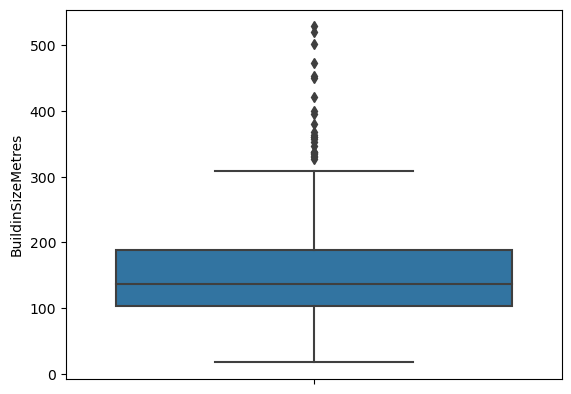

In [13]:
sns.boxplot(data = housing, y = 'BuildinSizeMetres')

In [14]:
housing.loc[housing.BuildinSizeMetres>40000]

,index,City,Address,Number_of_rooms,Type,Price_in_dollars,All_Method,REA,Dateofsold,DistanceKM,...,Bathroom,car_place,LandSizeMetres,BuildinSizeMetres,YearBuilt,CouncilArea,Lattitude,Longtitude,GeneralRegion,No_of_properties


* Ok, so this seems a very large property with a lot of land. The building area value is probably an error, as it is bigger than the landsize

In [15]:

housing['BuildinSizeMetres'].replace(44515.0, 445, inplace=True)

In [16]:
# check YearBuilt > 2018
print(housing['YearBuilt'].loc[housing.YearBuilt>2018])
#replace 2106 with 2016 and 2019 with 2018
housing['YearBuilt'].replace([2106, 2019], [2016, 2018], inplace=True)

Series([], Name: YearBuilt, dtype: float64)


<a id='data_cleaning'></a>

<a id='missing_data'></a>

### Missing data

In [17]:
# check missing data
housing.isnull().sum()

index                  0
City                   0
Address                0
Number_of_rooms        0
Type                   0
Price_in_dollars     286
All_Method             0
REA                    0
Dateofsold             0
DistanceKM             1
Postcode               1
Bathroom             290
car_place            309
LandSizeMetres       416
BuildinSizeMetres    779
YearBuilt            706
CouncilArea            1
Lattitude            286
Longtitude           286
GeneralRegion          1
No_of_properties       1
dtype: int64

Many of the variables suffer from missing values. Building area is the most affected by them. I would like to explore it's relationship with price and at the same time evaluate whether it is better to impute the missing values with their mean or median. 

In [18]:

priceWithMean = housing['Price_in_dollars'].fillna(housing['Price_in_dollars'].mean())
BAWithMean = housing['BuildinSizeMetres'].fillna(housing['BuildinSizeMetres'].mean())

#now with the median
priceMedian = housing['Price_in_dollars'].fillna(housing['Price_in_dollars'].median())
BAMedian = housing['BuildinSizeMetres'].fillna(housing['BuildinSizeMetres'].median())

In [19]:
missVIDsJoint = housing['Price_in_dollars'].isnull() | housing['BuildinSizeMetres'].isnull()


In [20]:
# create a dictionary to indicate different colors, missing values will be orange
colorChoiceDict = {True: (1.0, 0.55, 0.0, 1.0), False: (0.11, 0.65, 0.72, 0.1)}

# create a column with color values using list comprehension
colorCol = [colorChoiceDict[val] for val in missVIDsJoint]

Text(0, 0.5, 'Price_in_dollars')

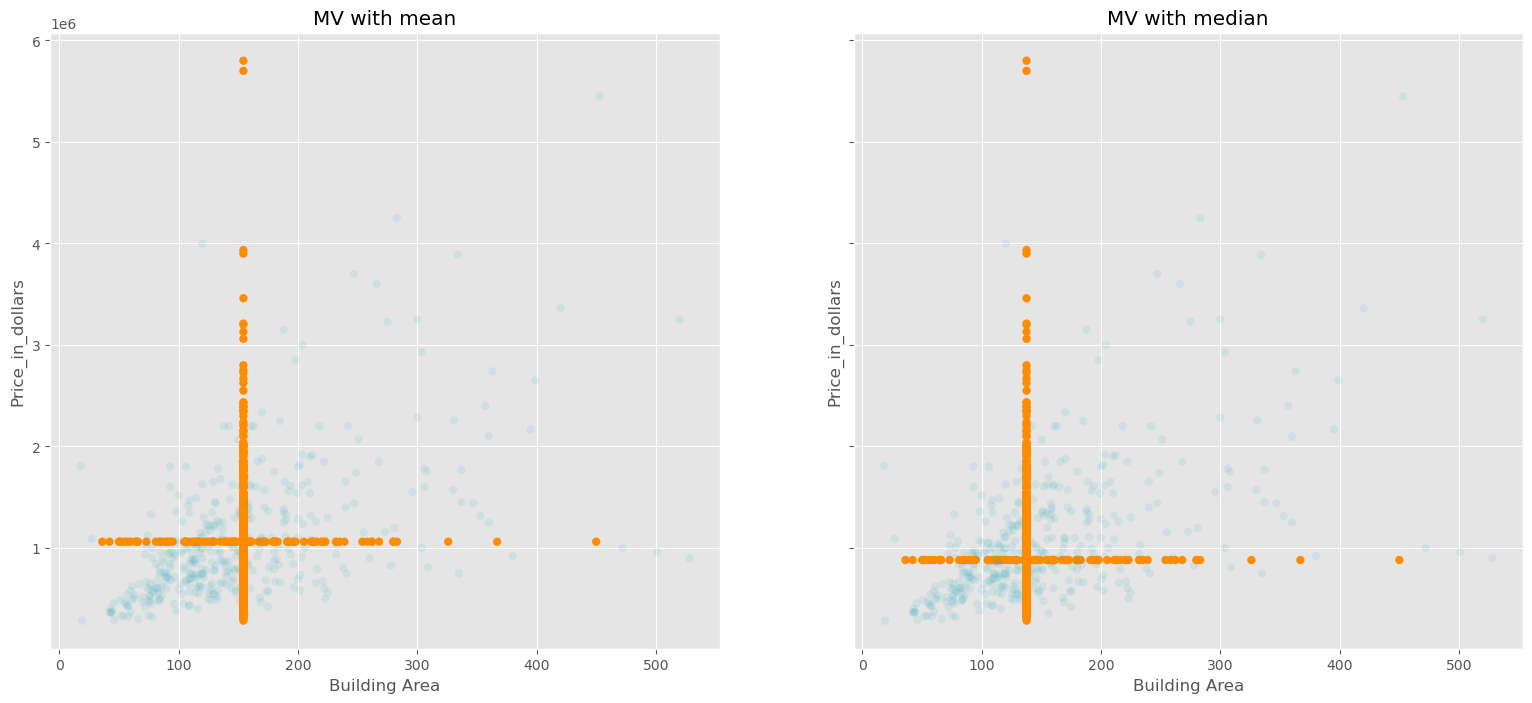

In [21]:
plt.style.use('ggplot')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(19, 8))
ax1.scatter(BAWithMean, priceWithMean, c = colorCol, linewidth=0)
ax1.set_title('MV with mean')
ax1.set_xlabel('Building Area')
ax1.set_ylabel('Price_in_dollars')
ax2.scatter(BAMedian, priceMedian, c = colorCol, linewidth=0)
ax2.set_title('MV with median')
ax2.set_xlabel('Building Area')
ax2.set_ylabel('Price_in_dollars')

In both graphs we can see where the imputed values would be. There is not a striking visual difference between the two graphs. However, after a careful look we can say that Price has a lot of outliers, and the median is less affected by them, as the horizontal line in the graph on the right is lower. 

In [22]:
housing['Price_in_dollars']= housing['Price_in_dollars'].fillna(housing['Price_in_dollars'].median())
housing['LandSizeMetres']= housing['LandSizeMetres'].fillna(housing['LandSizeMetres'].median())
#Similarly, fill the only missing value of  all the other numeric values
housing['DistanceKM'] = housing['DistanceKM'].fillna(housing['DistanceKM'].median())
housing['BuildinSizeMetres']= housing['BuildinSizeMetres'].fillna(housing['BuildinSizeMetres'].median())
housing['Lattitude']= housing['Lattitude'].fillna(housing['Lattitude'].median())
housing['Longtitude']= housing['Longtitude'].fillna(housing['Longtitude'].median())
housing['YearBuilt']= housing['YearBuilt'].fillna(housing['YearBuilt'].median())
housing.isnull().sum()

index                  0
City                   0
Address                0
Number_of_rooms        0
Type                   0
Price_in_dollars       0
All_Method             0
REA                    0
Dateofsold             0
DistanceKM             0
Postcode               1
Bathroom             290
car_place            309
LandSizeMetres         0
BuildinSizeMetres      0
YearBuilt              0
CouncilArea            1
Lattitude              0
Longtitude             0
GeneralRegion          1
No_of_properties       1
dtype: int64

Now the categorical variables. In this case I think the simplest way to deal with missing values is to sobstitute them with the mode

In [23]:
housing['Bathroom']= housing['Bathroom'].fillna(housing['Bathroom'].mode()[0])
housing['car_place']= housing['car_place'].fillna(housing['car_place'].mode()[0])
housing['CouncilArea']= housing['CouncilArea'].fillna(housing['CouncilArea'].mode()[0])
housing['GeneralRegion']= housing['GeneralRegion'].fillna(housing['GeneralRegion'].mode()[0])
housing['No_of_properties']= housing['No_of_properties'].fillna(housing['No_of_properties'].mode()[0])
housing['Postcode']= housing['Postcode'].fillna(housing['Postcode'].mode()[0])
housing.isnull().sum()

index                0
City                 0
Address              0
Number_of_rooms      0
Type                 0
Price_in_dollars     0
All_Method           0
REA                  0
Dateofsold           0
DistanceKM           0
Postcode             0
Bathroom             0
car_place            0
LandSizeMetres       0
BuildinSizeMetres    0
YearBuilt            0
CouncilArea          0
Lattitude            0
Longtitude           0
GeneralRegion        0
No_of_properties     0
dtype: int64

After deling with missing values, I can change the type of Bathroom and Car to integer

In [24]:
housing['Bathroom'] = pd.to_numeric(housing['Bathroom']).round(0).astype(int)
housing['car_place'] = pd.to_numeric(housing['car_place']).round(0).astype(int)

<a id='outliers'></a>

### Outliers

Another variable of great interest is distance. Let's visualize price and distance outliers. I would keep the threshold to identify outliers quite high in this situation. 

In [25]:
# create additional columns filled with 0 values
housing["isOutlierPrice"] = 0 
housing["isOutlierDistance"] = 0

# save the mean and standard deviation in variables
meanPrice = housing['Price_in_dollars'].mean()
stdDevPrice = housing['Price_in_dollars'].std()

meanDistance = housing['DistanceKM'].mean()
stdDevDistance = housing['DistanceKM'].std()

#mark outliers as 
housing['isOutlierPrice'] = np.where(abs(housing['Price_in_dollars'] - meanPrice) > 5 * stdDevPrice, 1, 0)
housing['isOutlierDistance'] = np.where(abs(housing['DistanceKM'] - meanDistance) > 5 * stdDevDistance, 1, 0)

In [26]:
#create a function to compute the percentage of missing values
def percent(nom, denom):
    res= (nom*100)/denom
    print("%.3f%%" % round(res,3))

#percentage of MV for Price
percent(housing["isOutlierPrice"].value_counts()[1], housing["isOutlierPrice"].value_counts()[0])   

0.633%


In [27]:
#percentage of MV for Landsize
percent(housing["isOutlierDistance"].value_counts()[1], housing["isOutlierDistance"].value_counts()[0])   

0.079%


With this high threshold, less than 1% of values are considered outliers. The next graph visualize this proportion. 

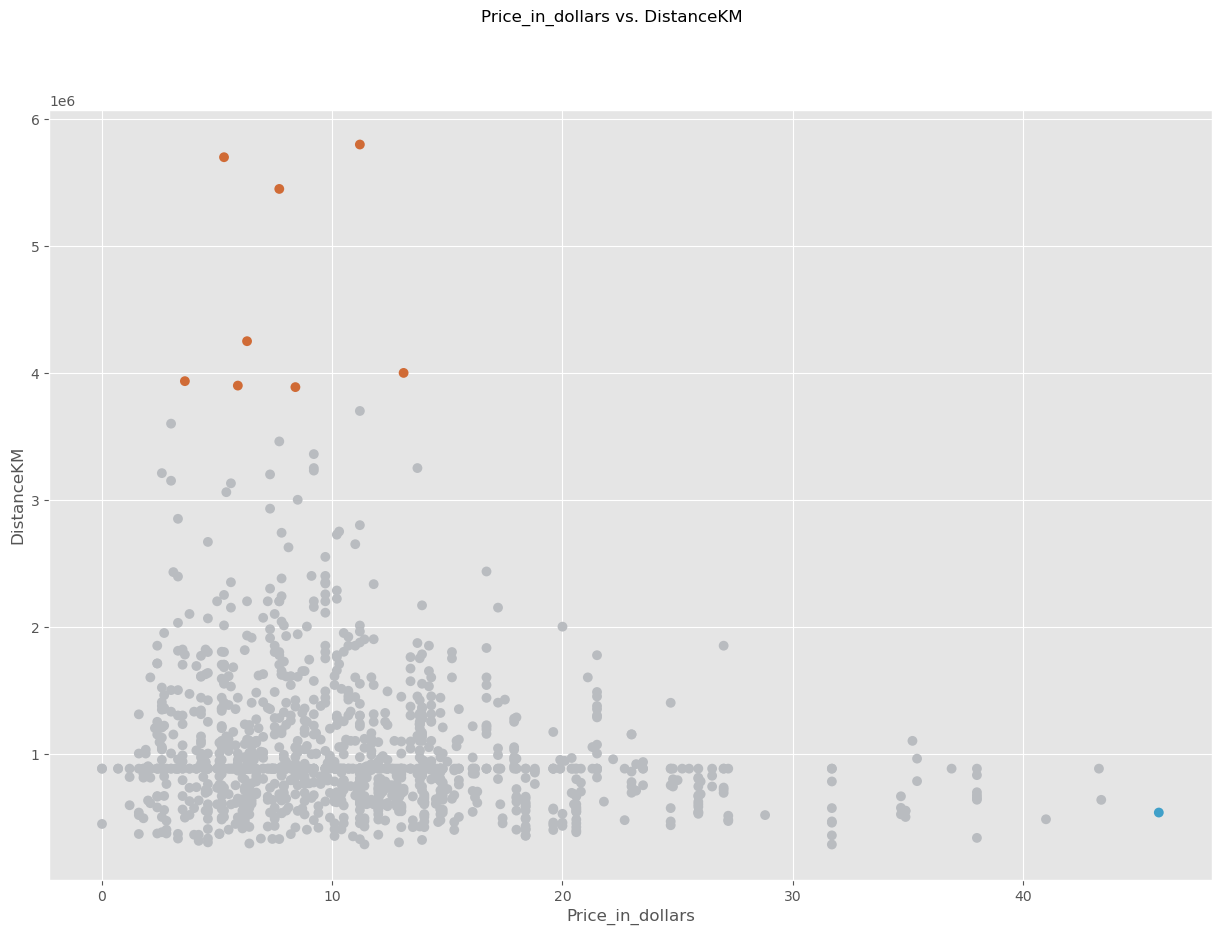

In [28]:
# This part helps us to generate a color array with different colors for the 1D outliers we compute

# first create an empty list
colorColumn = []
# we make use of the HEX color codes to use nicely distinguisable colors
for i in range(len(housing)):
    if housing["isOutlierPrice"][i]== 1:
        colorColumn.append("#D06B36") # orange color
    elif housing["isOutlierDistance"][i] == 1:
        colorColumn.append("#40A0C9") # a blueish color
    else:
        colorColumn.append("#B9BCC0") # gray

plt.figure(figsize=(15,10))
plt.xlabel('Price_in_dollars')
plt.suptitle('Price_in_dollars vs. DistanceKM')
plt.ylabel('DistanceKM')
plt.scatter(housing.DistanceKM, housing.Price_in_dollars , c = colorColumn, s = 50, linewidth=0)

In [29]:
#take just the price outlier
housing.iloc[:,:19][housing.Price_in_dollars > 11000000]

,index,City,Address,Number_of_rooms,Type,Price_in_dollars,All_Method,REA,Dateofsold,DistanceKM,Postcode,Bathroom,car_place,LandSizeMetres,BuildinSizeMetres,YearBuilt,CouncilArea,Lattitude,Longtitude


The revious visualization was a simple 1D outlier measure: each point was either an outlier either for price or distance. But what about those points that are 2D outliers, that is on the edge of the distribution for both variables? In order to detect those points we need high-dimensional methods. Mahalanobis distance is one such measure, which will help to realize our next graph. 

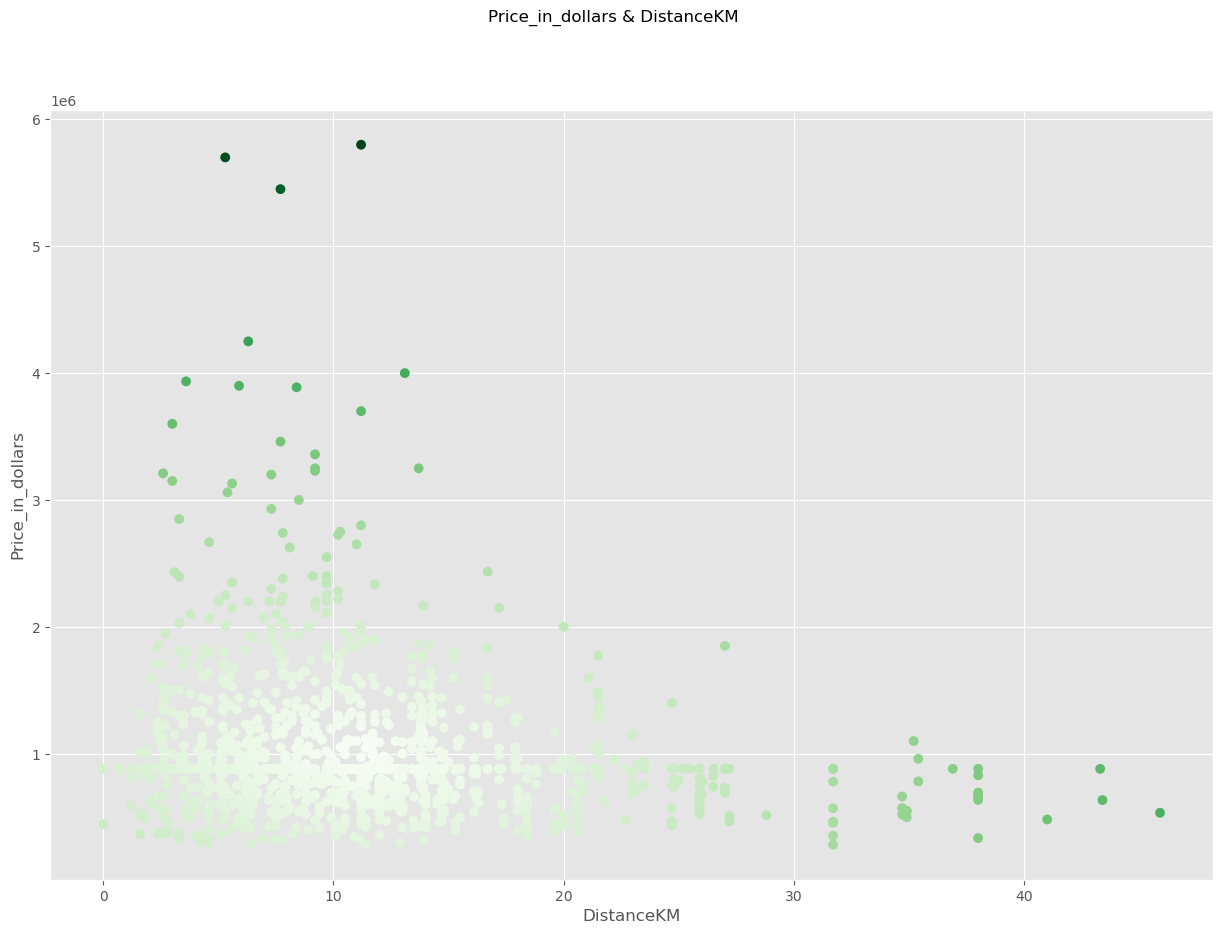

In [31]:
housing.dropna(inplace=True)  # Drop rows with missing values
columnValues = housing[["Price_in_dollars", "DistanceKM"]].to_numpy()

meanPrice = housing["Price_in_dollars"].mean()  # Calculate mean of Price_in_dollars
meanDistance = housing["DistanceKM"].mean()  # Calculate mean of DistanceKM
meanVector = np.asarray([meanPrice, meanDistance]).reshape(1, 2)

from scipy import spatial
mahalanobisDistances = spatial.distance.cdist(columnValues, meanVector, 'mahalanobis')[:,0]

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.xlabel('DistanceKM')
plt.suptitle('Price_in_dollars & DistanceKM')
plt.ylabel('Price_in_dollars')
plt.scatter(housing.DistanceKM, housing.Price_in_dollars, c=mahalanobisDistances, cmap=plt.cm.Greens, s=50, linewidth=0)
plt.show()


We can see that more "central" points have a low Mahalanobis distance (white points), while those on the outskirts have more saturated colors, i.e., higher distance to the centre. In this plot, the only clear 2D outliers are the dark points on the top left corner. Notice that Mahalanobis distance is particularly suited for elliptical relationship between variables (and this is not one of them). In any case is a nice visual method to identify groups of potentially interesting outliers. 

### 4.	Summarize relationships among variables (10 marks)  

a.	Plot correlation plots. Which are the variables most correlated with Target? Which independent variables are correlated among themselves? Do you want to exclude some variables from the model based on this analysis? What other actions will you take?

b.	Plot all independent variables with the target. Are all relationships linear? If not, what steps would you take based on this information?

 Hint: based on your observations you may want to transform features or create additional features.


<a id='features'></a>

* create variable number of years since building

In [32]:
housing['houseAge'] = 2018-housing['YearBuilt']

* Then create two new categories from the variable Date: year and season.

In [33]:
#create the new column data restructuring the original Date column with pd.to_datetime
housing['data'] = pd.to_datetime(housing['Dateofsold'])

C:\Users\Ashish\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '18-03-2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Ashish\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '28-10-2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Ashish\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '17-03-2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Ashish\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '17-06-2017' in DD/MM/YYYY format. Provide format or sp

In [34]:
# calculate day of year
housing['doy'] = housing['data'].dt.dayofyear
# Create year
housing['Year'] = housing['data'].dt.year

#to divide by season it's better to use the day of the year instead of the months
spring = range(80, 172)
summer = range(172, 264)
fall = range(264, 355)
# winter = everything else

daje = []
for i in housing['doy']:
    if i in spring:
        season = 'spring'
    elif i in summer:
        season = 'summer'
    elif i in fall:
        season = 'fall'
    else:
        season = 'winter'
    daje.append(season)   

#add the resulting column to the dataframe (after transforming it as a Series)
housing['season']= pd.Series(daje)

In [35]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1271 entries, 0 to 1270
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index              1271 non-null   int64         
 1   City               1271 non-null   object        
 2   Address            1271 non-null   object        
 3   Number_of_rooms    1271 non-null   int64         
 4   Type               1271 non-null   object        
 5   Price_in_dollars   1271 non-null   float64       
 6   All_Method         1271 non-null   object        
 7   REA                1271 non-null   object        
 8   Dateofsold         1271 non-null   object        
 9   DistanceKM         1271 non-null   float64       
 10  Postcode           1271 non-null   float64       
 11  Bathroom           1271 non-null   int32         
 12  car_place          1271 non-null   int32         
 13  LandSizeMetres     1271 non-null   float64       
 14  BuildinS

<a id='box'></a>

##### Boxplots and histograms

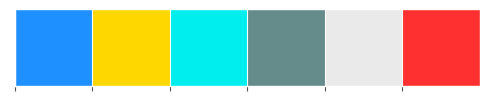

In [36]:
#create my palette
myPal = ["#1E90FF", "#FFD700", "#00EEEE", "#668B8B", "#EAEAEA", "#FF3030"]
sns.set_palette(myPal)
sns.palplot(sns.color_palette())

First let's check with boxplots the distribution of ordinal and categorical values

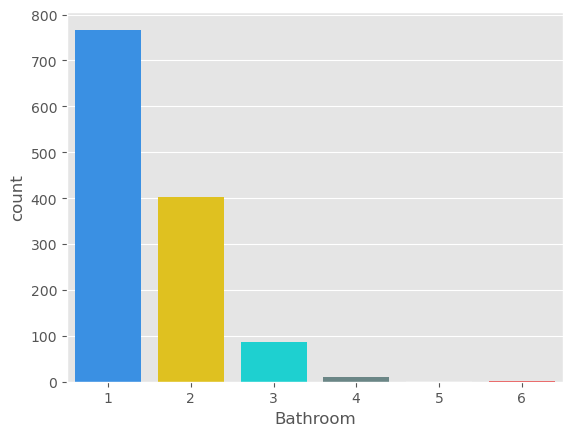

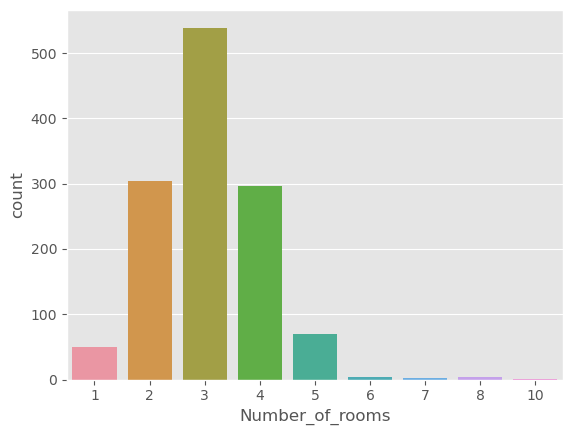

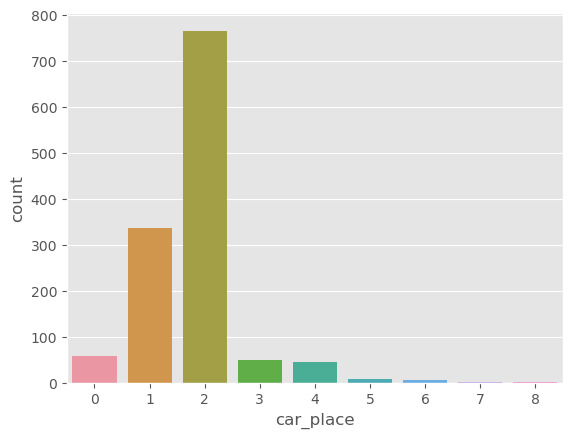

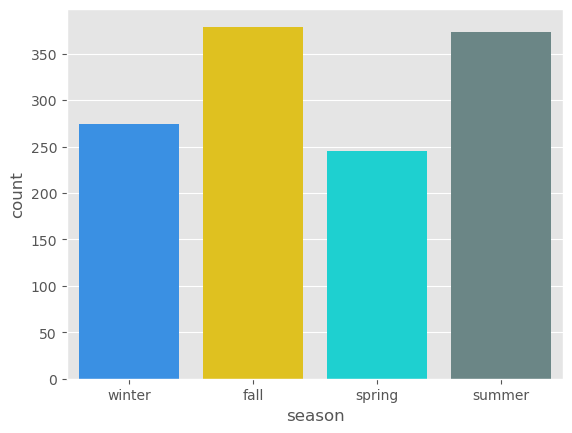

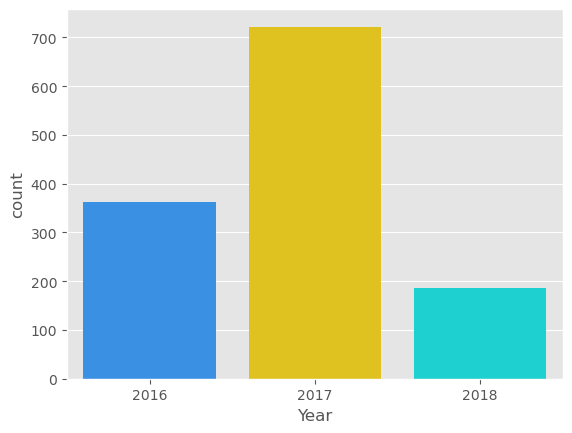

In [37]:
l= ['Bathroom', 'Number_of_rooms', 'car_place', 'season', 'Year']
for i in l:
    plt.figure()
    sns.countplot(x=i, data=housing)

**Insights**:

* most properties were sold on 2017;
* More properties are sold during summer and fall;
* most houses have space for 2 cars;
* between 2 to four rooms and 1 or 2 bathrooms;

Now I'll take a look at the distribution of continous variables using histograms

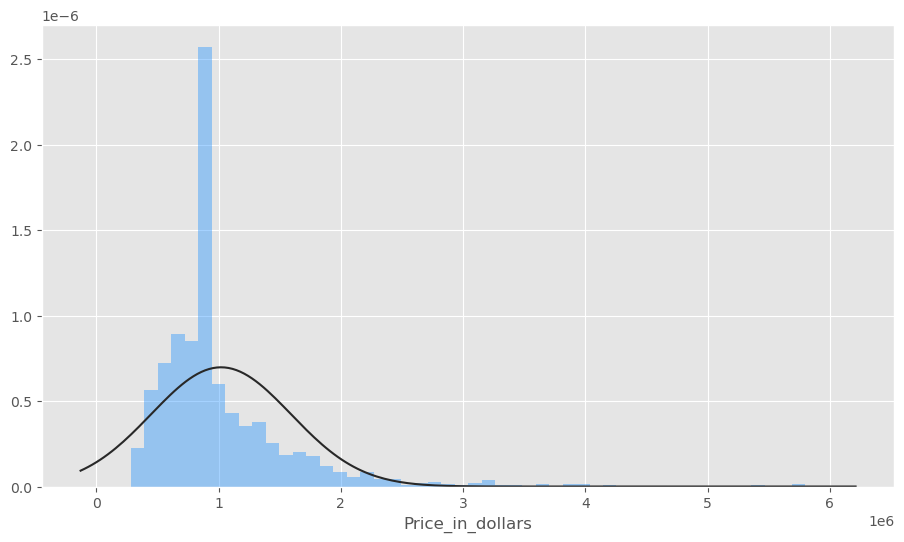

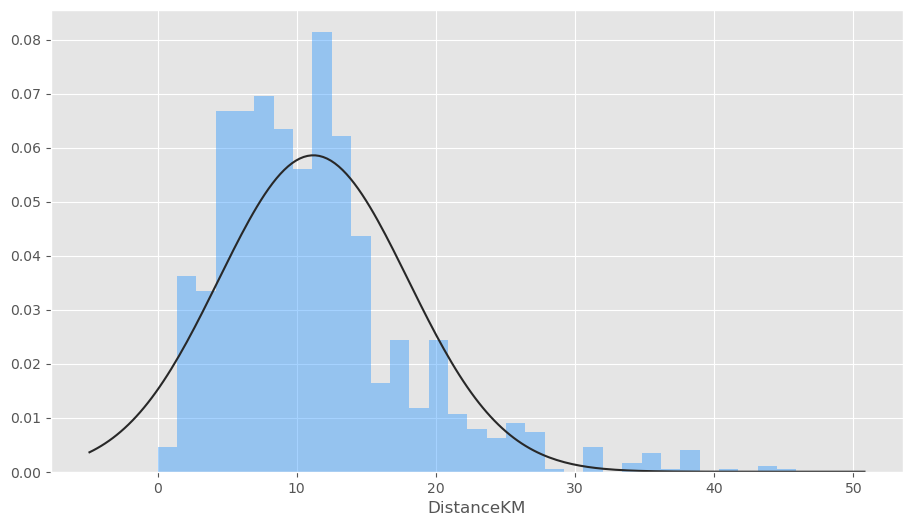

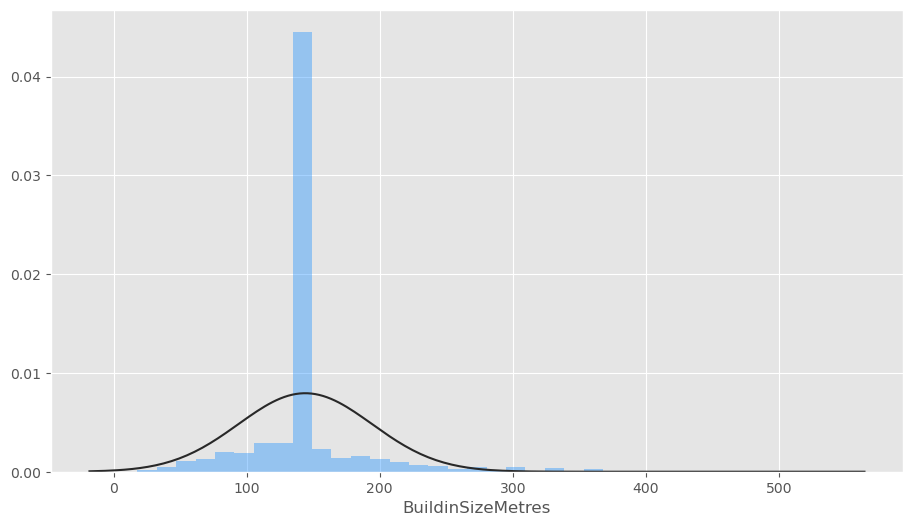

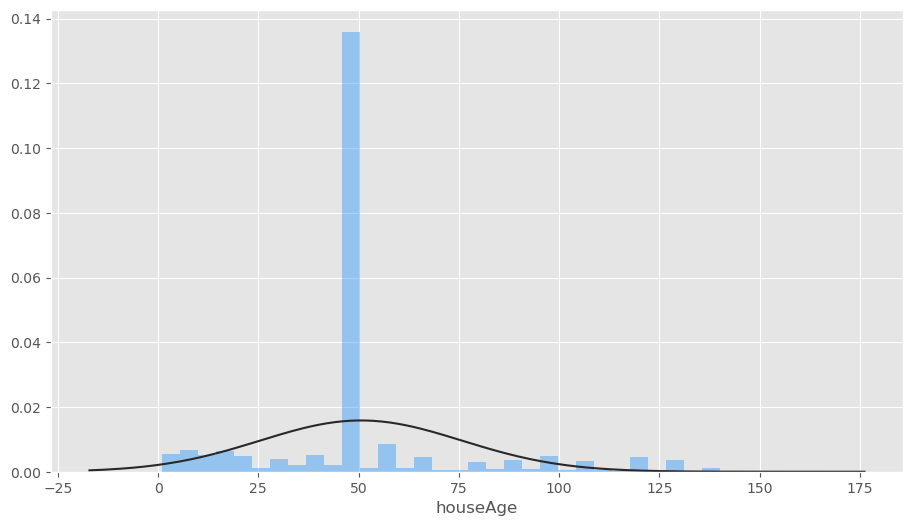

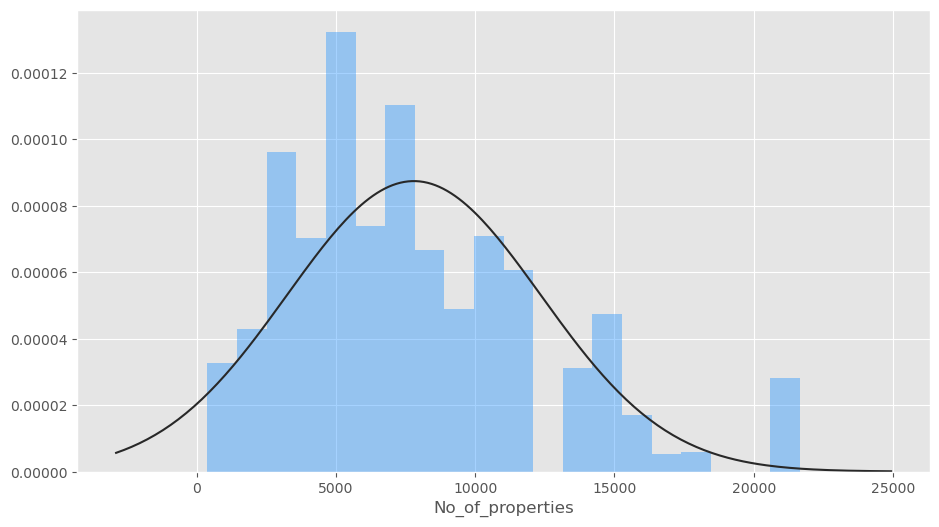

In [38]:
l= [housing['Price_in_dollars'], housing['DistanceKM'], housing['BuildinSizeMetres'], housing['houseAge'], housing['No_of_properties']]
for i in l:
    plt.figure(figsize=(11,6))
    sns.distplot(i, fit=norm, kde=False)

Let's zoom in for Building Area, which is not very clear by the last graph

(0.0, 1000.0)

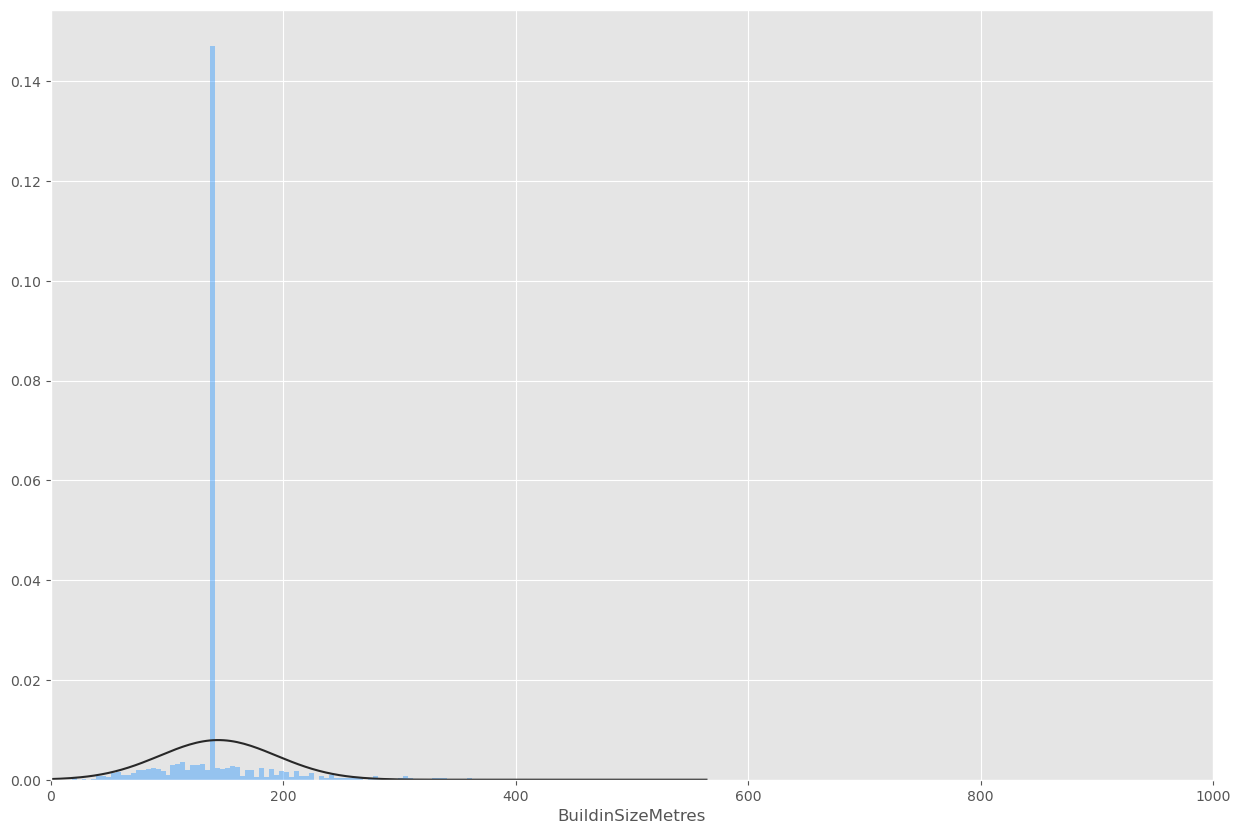

In [39]:
plt.figure(figsize=(15,10))
sns.distplot(housing['BuildinSizeMetres'], fit=norm, bins=120, kde=False)
plt.xlim(0,1000)

Biggest insight here is that all variables have a different scale, there are many outliers for most of them and no one seem really close to normality. These observations will come useful later when I will scale my features. 

Now let us check some variables that may influence our dependent variable price. 

Text(0.5, 1.0, 'Number_of_rooms & Price_in_dollars')

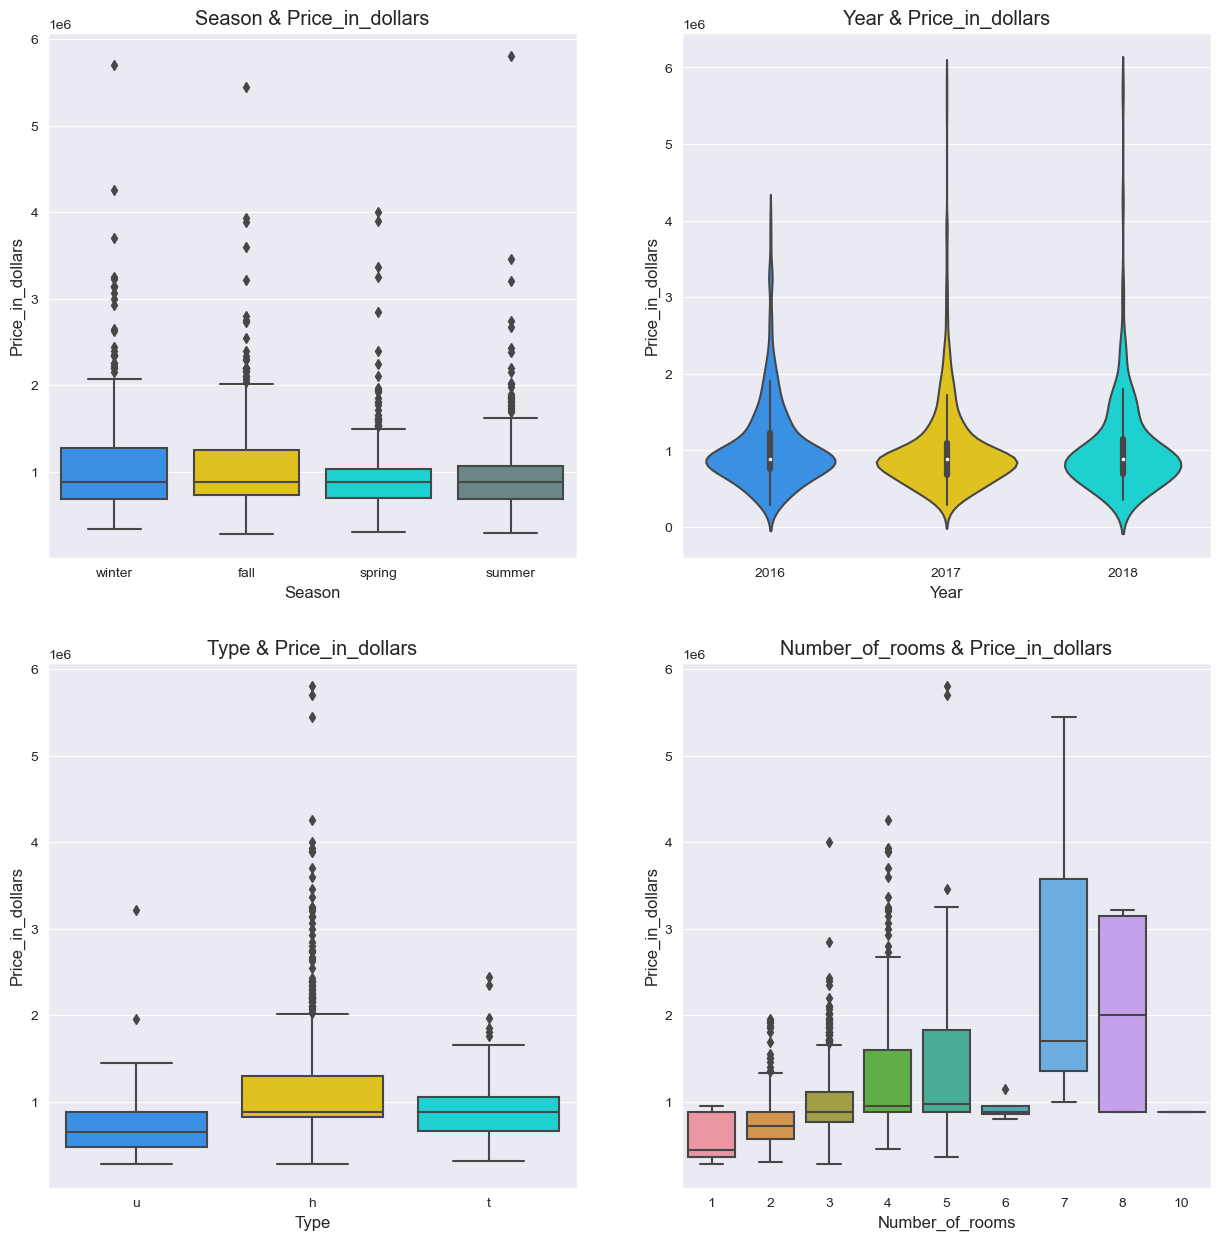

In [40]:
# Suplots of categorical features v price
sns.set_style('darkgrid')
f, axes = plt.subplots(2,2, figsize = (15,15))

# Plot [0,0]
sns.boxplot(data = housing, x = 'season', y = 'Price_in_dollars', ax = axes[0, 0])
axes[0,0].set_xlabel('Season')
axes[0,0].set_ylabel('Price_in_dollars')
axes[0,0].set_title('Season & Price_in_dollars')

# Plot [0,1]
sns.violinplot(data = housing, x = 'Year', y = 'Price_in_dollars', ax = axes[0, 1])
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Price_in_dollars')
axes[0,1].set_title('Year & Price_in_dollars')

# Plot [1,0]
sns.boxplot(x = 'Type', y = 'Price_in_dollars', data = housing, ax = axes[1,0])
axes[1,0].set_xlabel('Type')
axes[1,0].set_ylabel('Price_in_dollars')
axes[1,0].set_title('Type & Price_in_dollars')

# Plot [1,1]
sns.boxplot(x = 'Number_of_rooms', y = 'Price_in_dollars', data = housing, ax = axes[1,1])
axes[1,1].set_xlabel('Number_of_rooms')
axes[1,1].set_ylabel('Price_in_dollars')
axes[1,1].set_title('Number_of_rooms & Price_in_dollars')

* Regarding season, there is no big diffence in price between houses sold on different parts of the year;  
* As for years, 2017 was the best year for the market, with apparently more high price outliers. 2018 has less activity, perhaps because data collection did not include the whole year. 
* It seems that there is a slight linear increase in Price for more rooms. Note that not all the levels of variable rooms are very stable

* Type of house may be an important indicator for price, as is seems that h (cottages) cost more, and have more variability in price. 

<a id='time'></a>

##### Time series plots

we obviously to organize the longitudinal plot wth days on the x-axis and price as y. Considering the size of the dataset we expected to have house sales for almost every day.

In [41]:
housing.pivot_table('Price_in_dollars', index='data', aggfunc='sum').shape

(72, 1)

([<matplotlib.axis.XTick at 0x238f3983d00>,
 [Text(0, 0, ''),
  Text(1, 0, 'January'),
  Text(2, 0, 'February'),
  Text(3, 0, 'March'),
  Text(4, 0, 'April'),
  Text(5, 0, 'May'),
  Text(6, 0, 'June'),
  Text(7, 0, 'July'),
  Text(8, 0, 'August'),
  Text(9, 0, 'September'),
  Text(10, 0, 'October'),
  Text(11, 0, 'November'),
  Text(12, 0, 'December')])

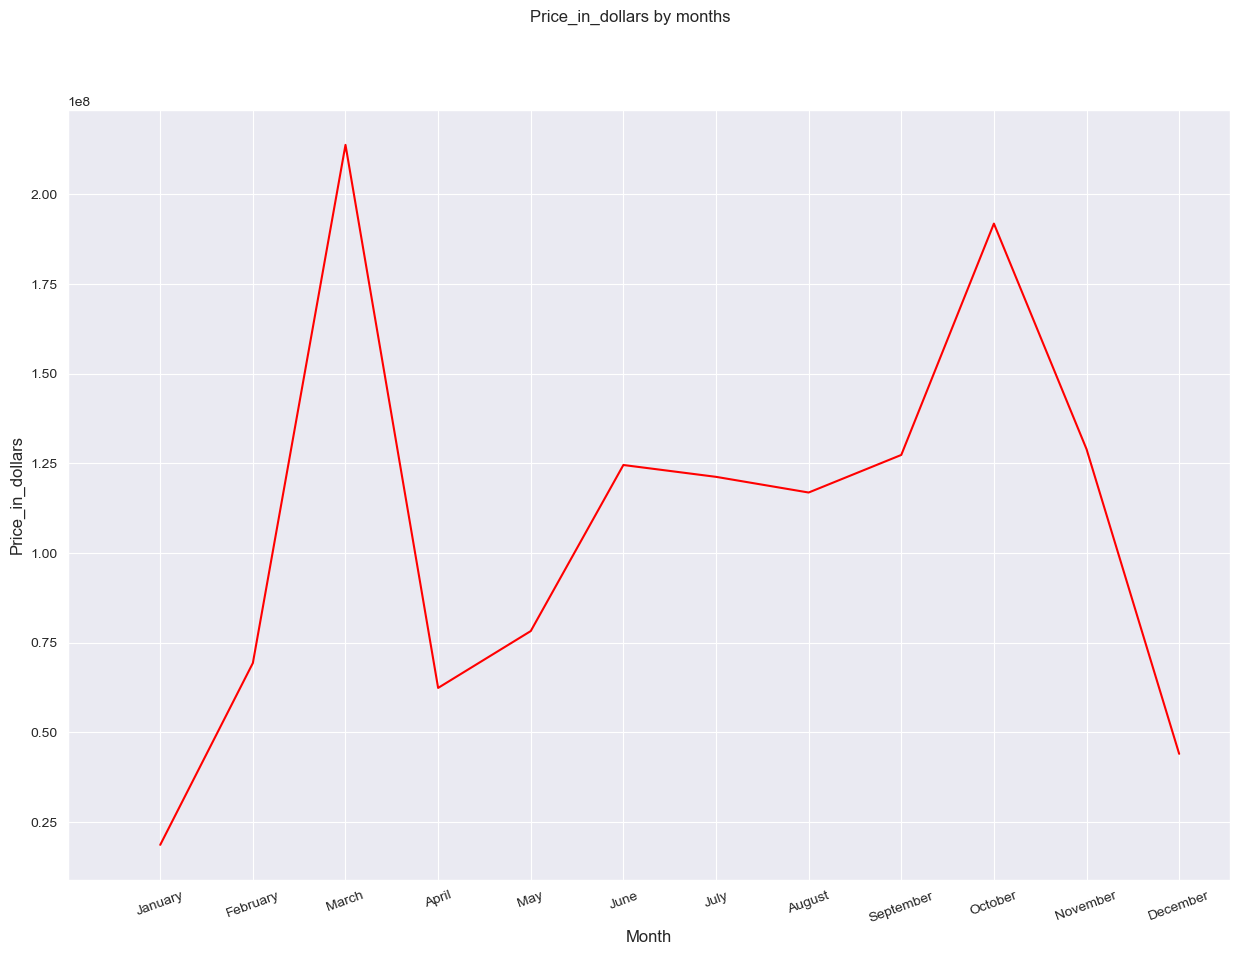

In [42]:
import calendar
# create new column storing the month of each operation
housing['month'] = housing['data'].dt.month
#use group by (alternative to pivot_table) to have the total value of houses sold per month
by_month= housing.groupby('month')['Price_in_dollars'].sum()
#plot figure
plt.figure(figsize=(15,10))
plt.plot(by_month, color="red")
plt.xlabel('Month')
plt.suptitle('Price_in_dollars by months')
plt.ylabel('Price_in_dollars')
plt.xticks(np.arange(13), calendar.month_name[0:13], rotation=20)

In the graph above I simply consider Price by month, similarly to what I did before with boxplots. 

[Text(554, 0, '2016-03'),
 Text(555, 0, '2016-04'),
 Text(556, 0, '2016-05'),
 Text(557, 0, '2016-06'),
 Text(558, 0, '2016-07'),
 Text(559, 0, '2016-08'),
 Text(560, 0, '2016-09'),
 Text(561, 0, '2016-10'),
 Text(562, 0, '2016-11'),
 Text(563, 0, '2016-12'),
 Text(564, 0, '2017-01'),
 Text(565, 0, '2017-02'),
 Text(566, 0, '2017-03'),
 Text(567, 0, '2017-04'),
 Text(568, 0, '2017-05'),
 Text(569, 0, '2017-06'),
 Text(570, 0, '2017-07'),
 Text(571, 0, '2017-08'),
 Text(572, 0, '2017-09'),
 Text(573, 0, '2017-10'),
 Text(574, 0, '2017-11'),
 Text(575, 0, '2017-12'),
 Text(577, 0, '2018-02'),
 Text(578, 0, '2018-03'),
 Text(581, 0, '2018-06'),
 Text(585, 0, '2018-10')]

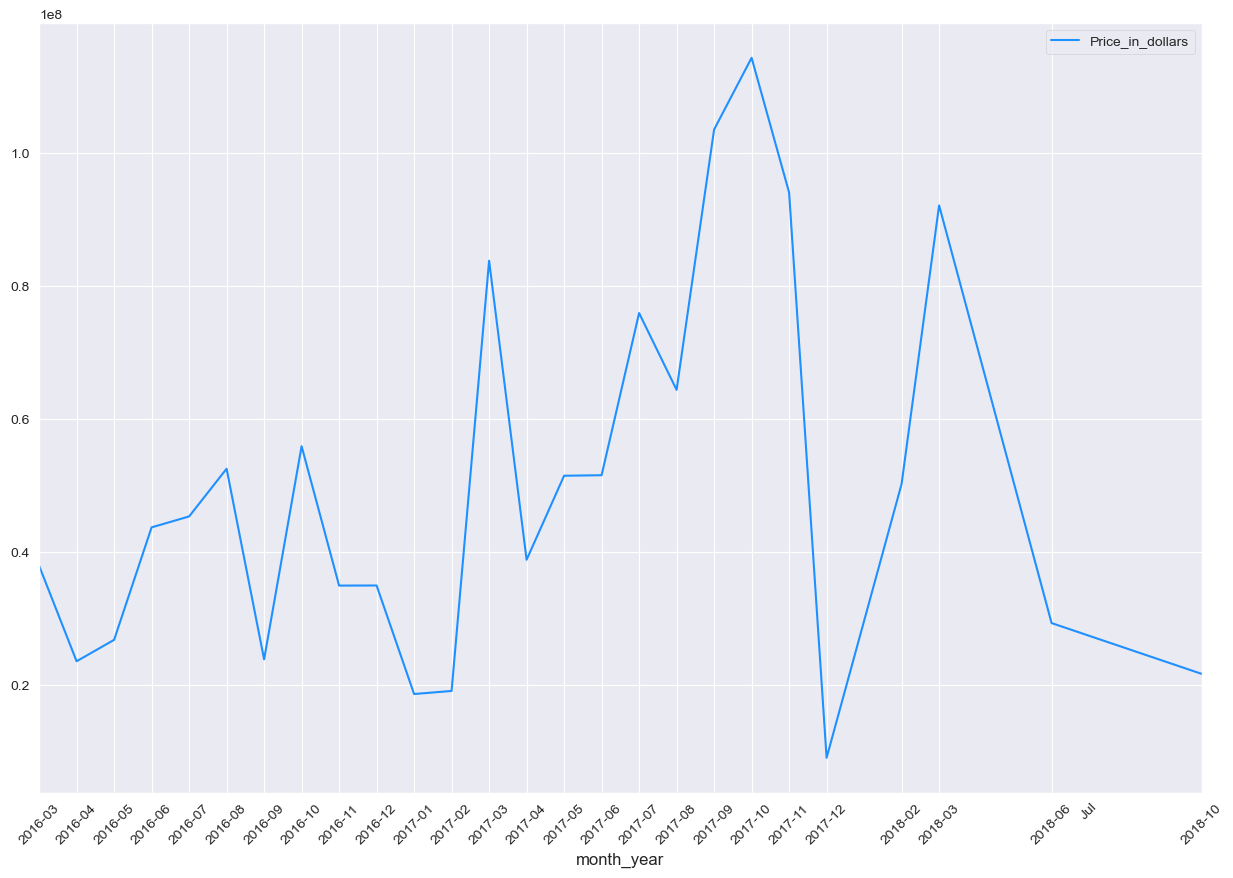

In [43]:
#create index month-year
housing['month_year'] = housing['data'].dt.to_period('M')
#use groupby to compute the price for each available month, then store the result in a dataframe
by_year_month= pd.Series.to_frame(housing.groupby('month_year')['Price_in_dollars'].sum())
#draw graph
fig, ax = plt.subplots(figsize=(15,10))
by_year_month.plot(ax=ax, xticks=by_year_month.index, rot=45)
ax.set_xticklabels(by_year_month.index)

<a id='correlation'></a>

#### Correlation matrix and scatterplots

It is high time to have a look at the correlations between our variables. First I will draw a correlation matrix, and then I will visualize the most promising relationship with scatterplots. 

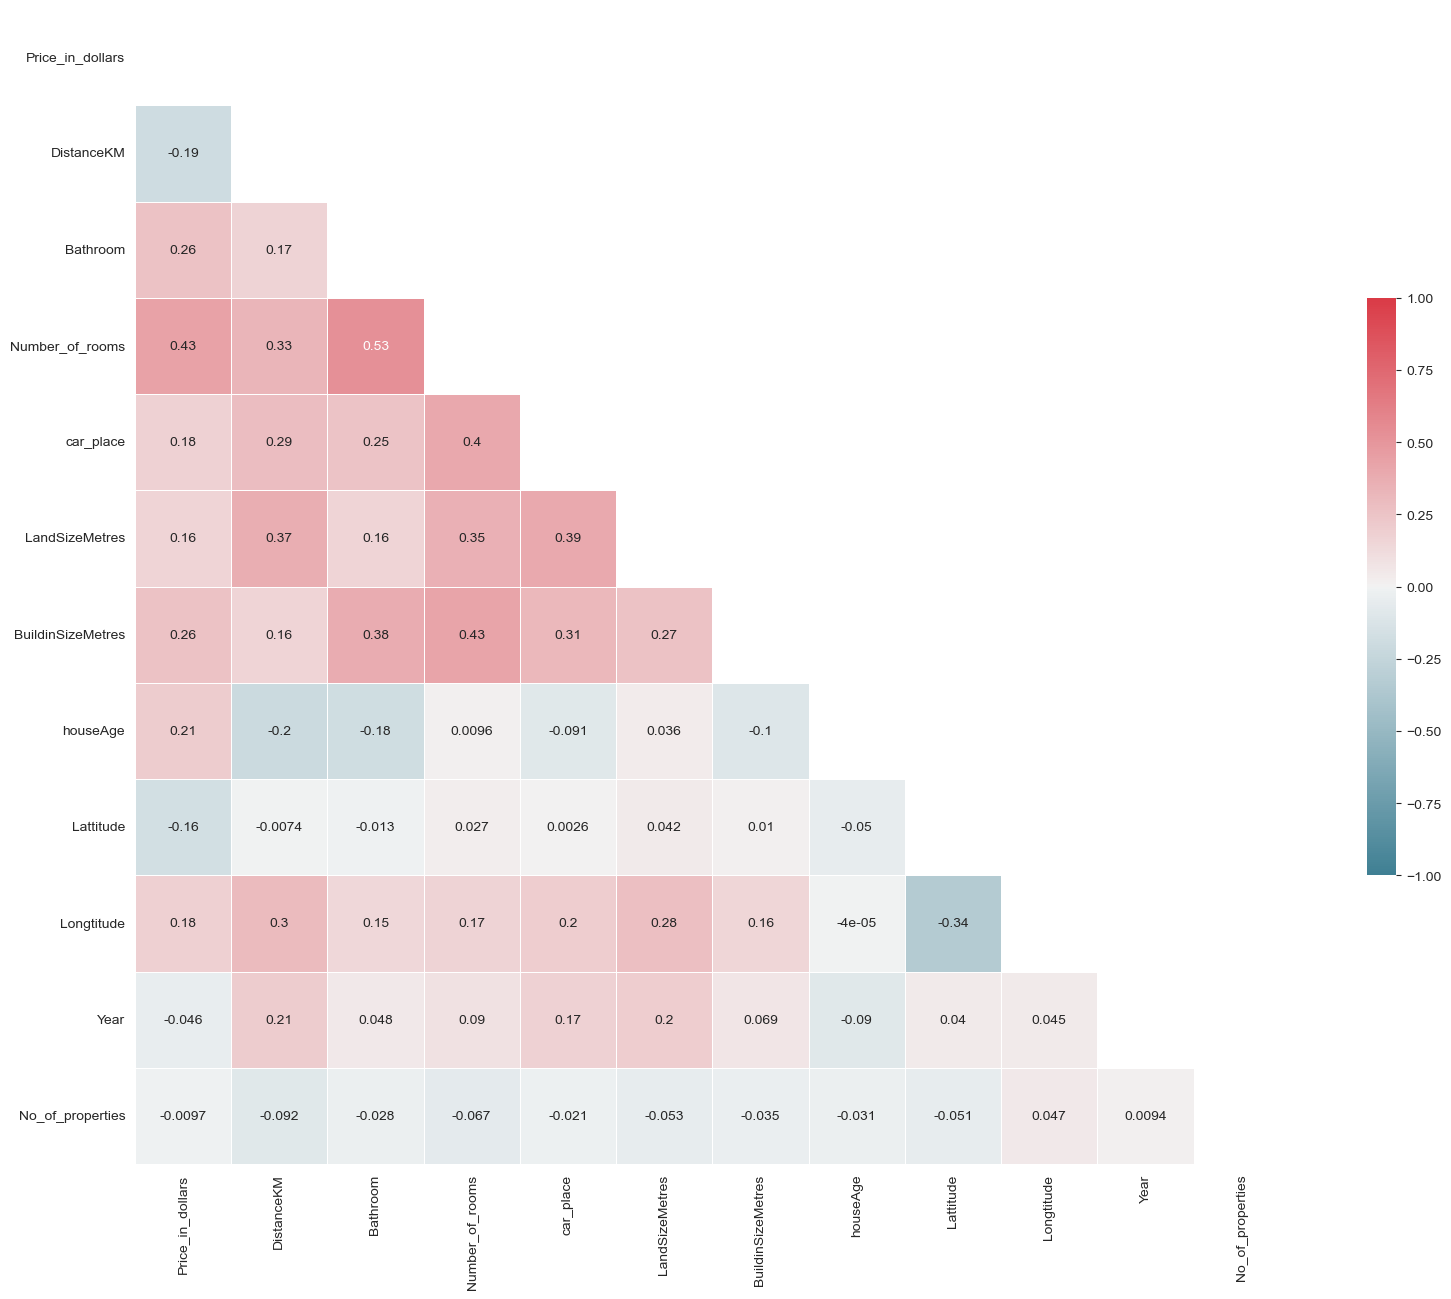

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the data we are interested in
attributes = ['Price_in_dollars', 'DistanceKM', 'Bathroom', 'Number_of_rooms', 'car_place', 'LandSizeMetres', 'BuildinSizeMetres', 'houseAge', 'Lattitude', 'Longtitude', 'Year', 'No_of_properties']
h = housing[attributes]

# Whitegrid style
sns.set_style('whitegrid')

# Compute correlation matrix
corr_matrix = h.corr(method='spearman')

# Define the dimension
plt.figure(figsize=(20,15))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0, vmax=1, vmin=-1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


I will now examine the relationship between Price and four other variables:
* BuildingArea (r= .24)
* HouseAge (.2)
* Rooms - This is the strongest relationship (.43). 
* Distance - most negative correlation (-.18)

<AxesSubplot:xlabel='DistanceKM', ylabel='Price_in_dollars'>

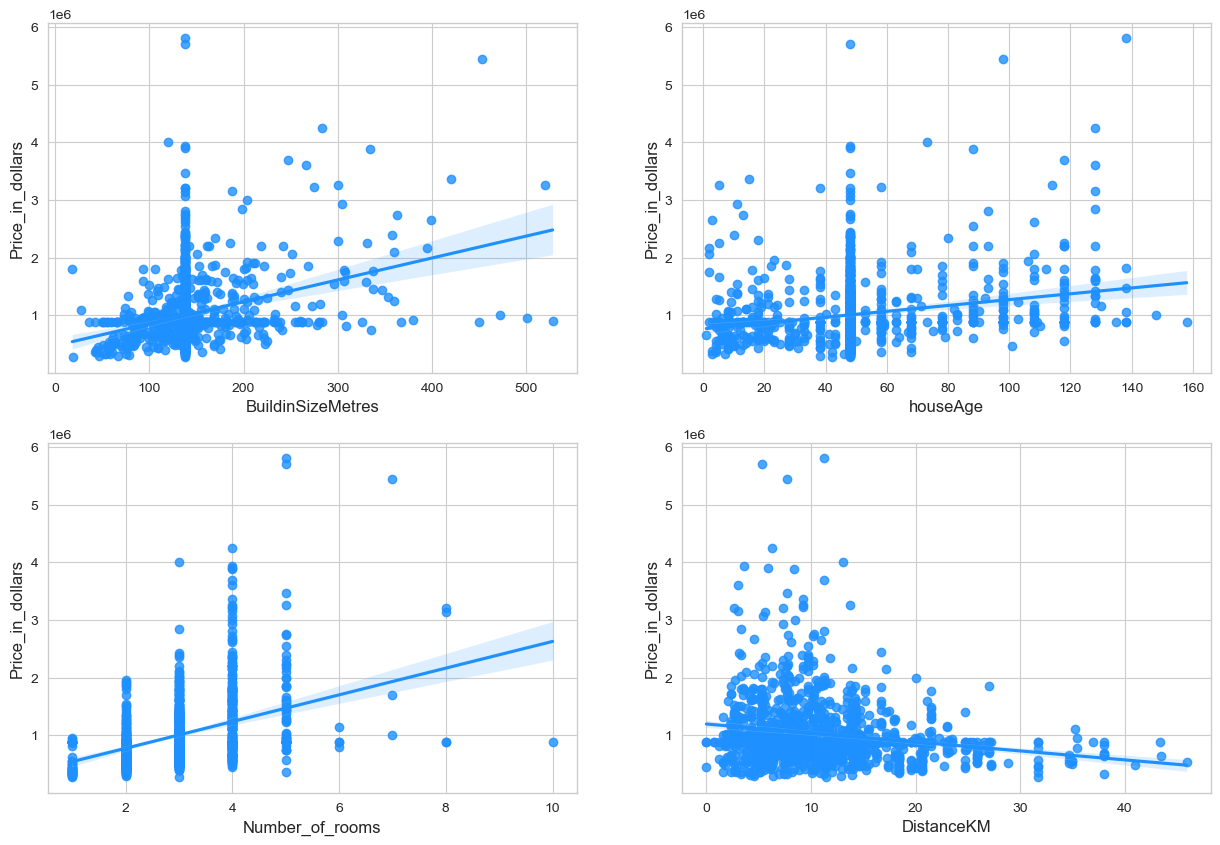

In [47]:
# Scatterplot
f, axes = plt.subplots(figsize = (15,10))
plt.subplot(221)
sns.regplot(data= housing, x='BuildinSizeMetres', y='Price_in_dollars')
plt.subplot(222)
sns.regplot(data= housing, x='houseAge', y='Price_in_dollars')
plt.subplot(223)
sns.regplot(data= housing, x='Number_of_rooms', y='Price_in_dollars')
plt.subplot(224)
sns.regplot(data= housing, x='DistanceKM', y='Price_in_dollars')

Seaborn provides other interesting options to visualize a bivariate relationship, like the jointplot below. This time I used a trick to stop some useless warning that I was not able to fix in any other way.

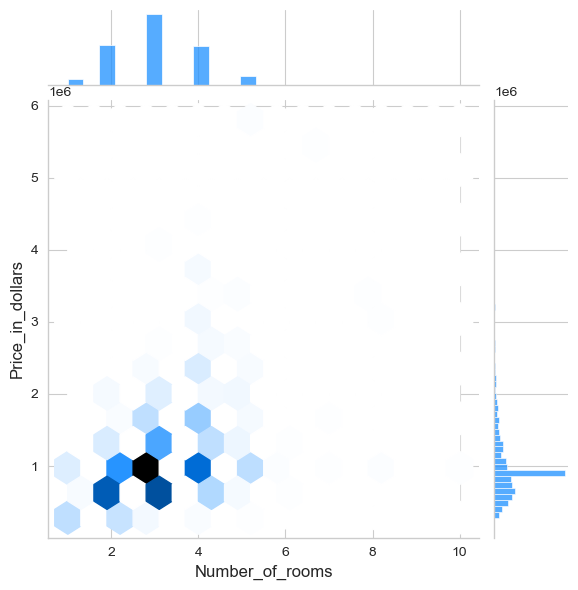

In [48]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Price and distance
    sns.jointplot(y='Price_in_dollars', x='Number_of_rooms', data=housing, kind='hex', gridsize=15)

Is the type of house influencing the relationship of the variables we examined? For example, when a townhouse gets old I think that it loses value, as we tend to prize more modern venues in western cities. But what about an historical villa deep into the countryside? In that case I think that the price may well increase as the property ages, like a vintage item. 

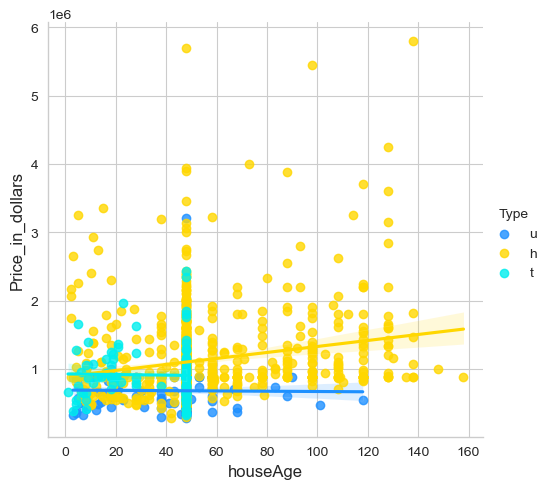

In [49]:
sns.lmplot(data= housing, x='houseAge', y= 'Price_in_dollars', hue= 'Type')

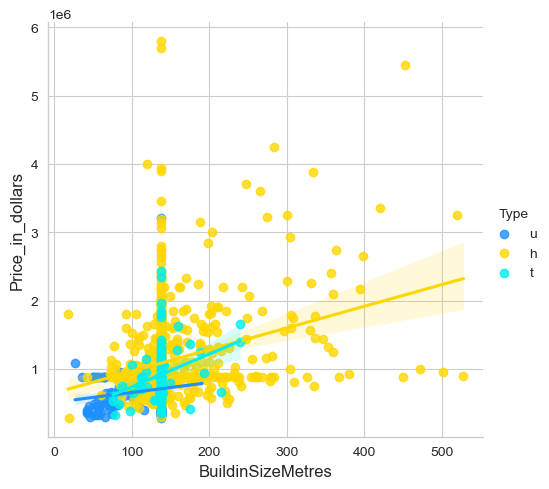

In [50]:
sns.lmplot(data= housing, x='BuildinSizeMetres', y= 'Price_in_dollars', hue='Type')

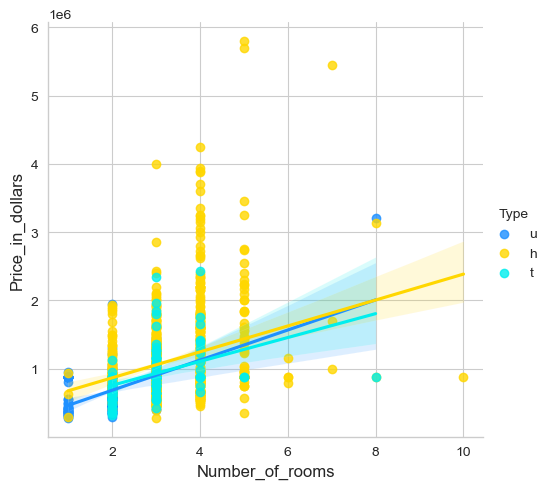

In [51]:
sns.lmplot(data= housing, x='Number_of_rooms', y= 'Price_in_dollars', hue='Type')

Indeed, it seems that there is an interaction between type of house and its age to determine the price: as the house gets older, the price increases on average, but this is particularly true for Type h, that is cottages and villas.

<a id='geo'></a>

#####  Geographical Data plotting

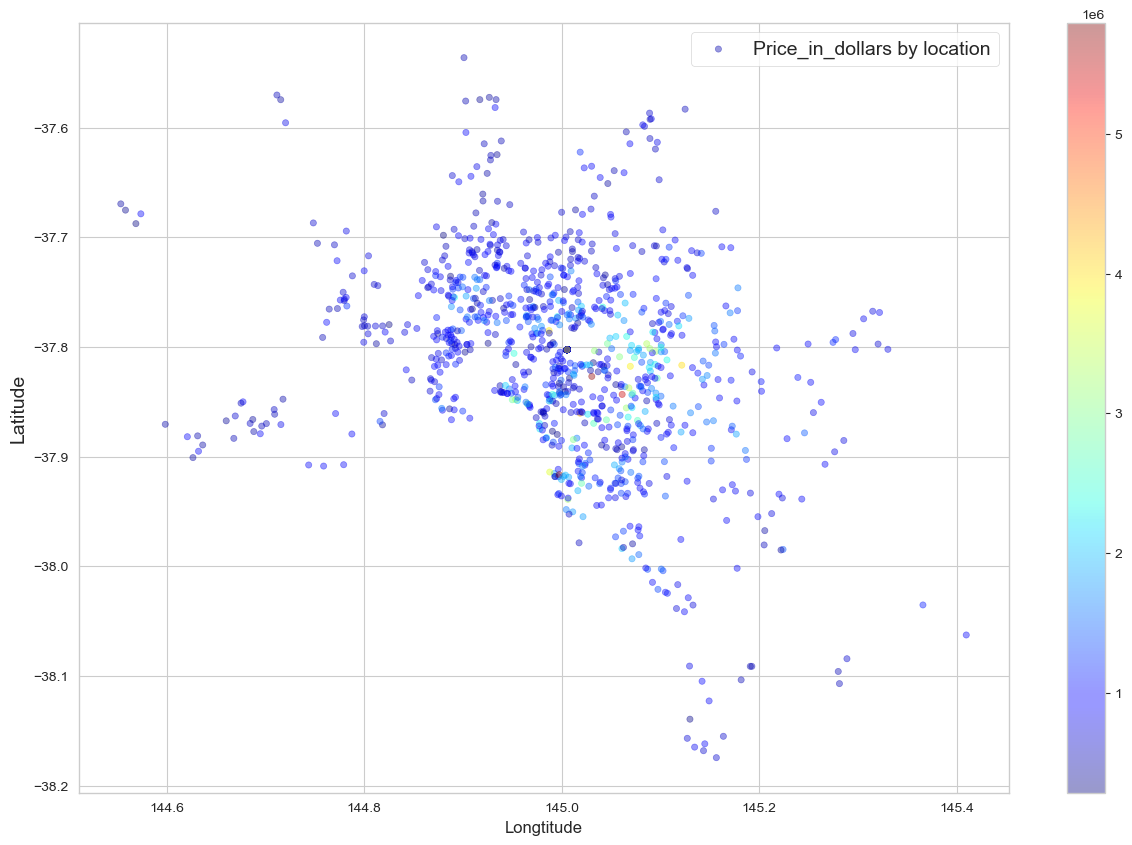

In [52]:
housing.plot(kind="scatter", x="Longtitude", y="Lattitude", alpha=0.4,
c=housing.Price_in_dollars, cmap=plt.get_cmap("jet"), label= 'Price_in_dollars by location', figsize=(15,10)) 
plt.ylabel("Latitude", fontsize=14)

plt.legend(fontsize=14)

This plot is quite confusing, because most values are in the low end of the Price range and they turn out as blue. 

In [53]:
housing['Price_cut']= housing['Price_in_dollars'].loc[housing.Price_in_dollars<3500000]

Text(0.5, 1.0, 'AFTER CUT')

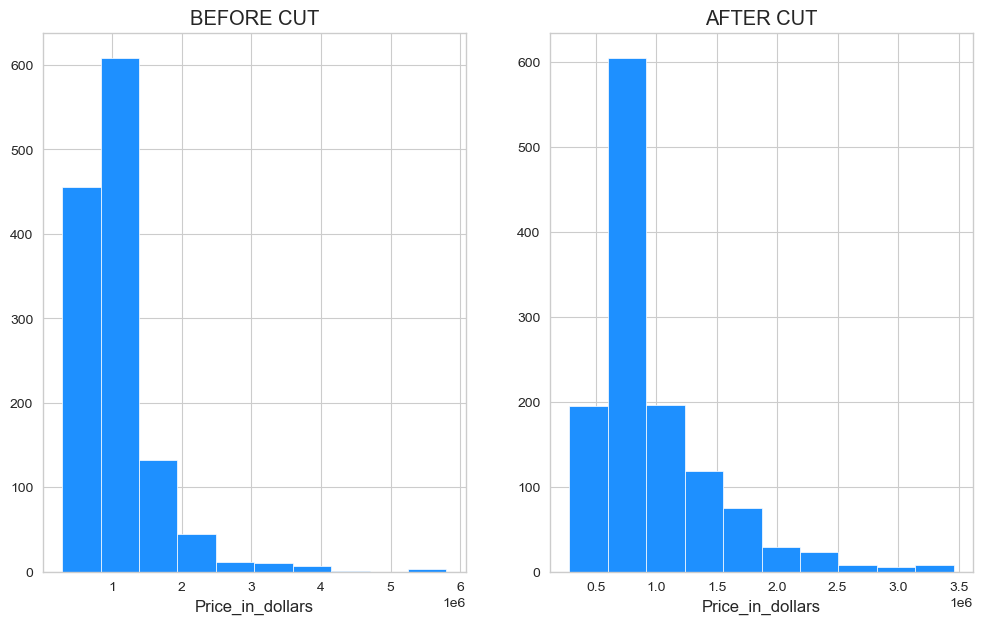

In [54]:
f, axes = plt.subplots(1,2, figsize = (12,7))
# Plot [0,0] full price
housing['Price_in_dollars'].hist(ax = axes[0])
axes[0].set_title('BEFORE CUT')
axes[0].set_xlabel('Price_in_dollars')
# Plot [0,1] price cut
housing['Price_cut'].hist(ax = axes[1])
axes[1].set_xlabel('Price_in_dollars')
axes[1].set_title('AFTER CUT')

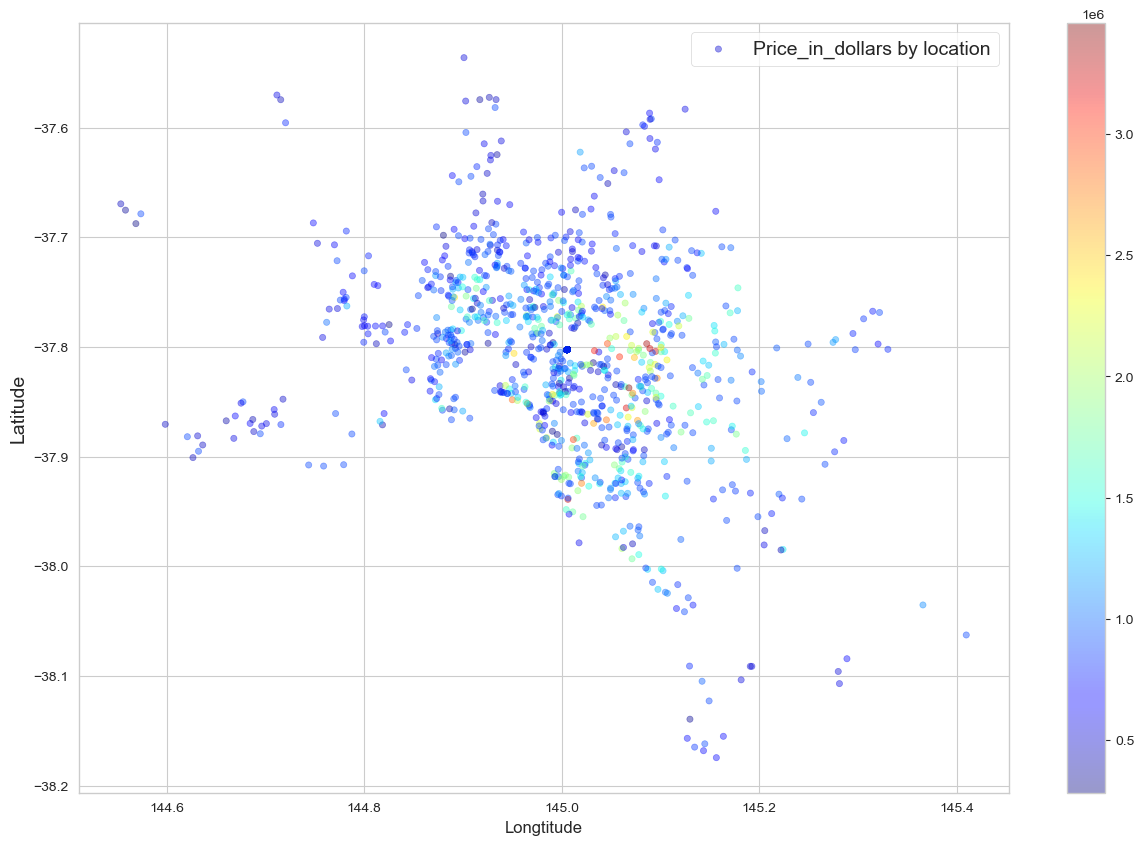

In [55]:
housing.plot(kind="scatter", x="Longtitude", y="Lattitude", alpha=0.4,
c=housing.Price_cut, cmap=plt.get_cmap("jet"), label= 'Price_in_dollars by location', figsize=(15,10)) 
plt.ylabel("Latitude", fontsize=14)

plt.legend(fontsize=14)

This map let us see that most expensive properties are in a central area not too far from what I think is the sea. Next step would be to superimpose on this scatterplot a real map of the city.

#### Hint: based on your observations you may want to transform features or create additional features.

<a id='ml'></a>

**One-hot encoding** for categorical variables

In [56]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1271 entries, 0 to 1270
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index              1271 non-null   int64         
 1   City               1271 non-null   object        
 2   Address            1271 non-null   object        
 3   Number_of_rooms    1271 non-null   int64         
 4   Type               1271 non-null   object        
 5   Price_in_dollars   1271 non-null   float64       
 6   All_Method         1271 non-null   object        
 7   REA                1271 non-null   object        
 8   Dateofsold         1271 non-null   object        
 9   DistanceKM         1271 non-null   float64       
 10  Postcode           1271 non-null   float64       
 11  Bathroom           1271 non-null   int32         
 12  car_place          1271 non-null   int32         
 13  LandSizeMetres     1271 non-null   float64       
 14  BuildinS

In [57]:
#dummy variable
hD= pd.get_dummies(housing, columns= ['Type', 'GeneralRegion', 'season'])
#drop useless variables
hD= hD.drop(['City', 'Address', 'All_Method', 'REA', 'Dateofsold', 'Postcode', 'CouncilArea', 'isOutlierPrice', 'isOutlierDistance',
            'YearBuilt', 'data', 'doy', 'month', 'month_year', 'Price_cut'], axis=1)
#check variables
hD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1271 entries, 0 to 1270
Data columns (total 28 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   index                                     1271 non-null   int64  
 1   Number_of_rooms                           1271 non-null   int64  
 2   Price_in_dollars                          1271 non-null   float64
 3   DistanceKM                                1271 non-null   float64
 4   Bathroom                                  1271 non-null   int32  
 5   car_place                                 1271 non-null   int32  
 6   LandSizeMetres                            1271 non-null   float64
 7   BuildinSizeMetres                         1271 non-null   float64
 8   Lattitude                                 1271 non-null   float64
 9   Longtitude                                1271 non-null   float64
 10  No_of_properties                    

### **Feature Scaling**



In [58]:

X = hD.drop("Price_in_dollars", axis=1)
Y = hD["Price_in_dollars"].copy()

scaler = RobustScaler()
hD= scaler.fit_transform(hD.astype(np.float64))

In [59]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = .20, random_state= 42)

##### Fit our three basic models...

In [60]:
#fit decision tree
tree = DecisionTreeRegressor()
tree.fit(x_train, y_train)
#fit random forest
forest = RandomForestRegressor(n_jobs=-1)
forest.fit(x_train, y_train)
#fit regression
lin_reg = LinearRegression(n_jobs=-1)
lin_reg.fit(x_train, y_train)

LinearRegression(n_jobs=-1)

... and then test them on train data, in terms of MSE:

In [61]:
models= [('lin_reg', lin_reg), ('random forest', forest), ('decision tree', tree)]
from sklearn.metrics import mean_squared_error
for i, model in models:    
    predictions = model.predict(x_train)
    MSE = mean_squared_error(y_train, predictions)
    RMSE = np.sqrt(MSE)
    msg = "%s = %.2f" % (i, round(RMSE, 2))
    print('RMSE of', msg)

RMSE of lin_reg = 445768.15
RMSE of random forest = 168065.02
RMSE of decision tree = 0.00


We can use the Mean absolute percentage error (MAPE) to compute a measure of accuracy that is more immediate to understand.

In [62]:
for i, model in models:
    # Make predictions on train data
    predictions = model.predict(x_train)
    # Performance metrics
    errors = abs(predictions - y_train)
    # Calculate mean absolute percentage error (MAPE)
    mape = np.mean(100 * (errors / y_train))
    # Calculate and display accuracy
    accuracy = 100 - mape    
    #print result
    msg = "%s= %.2f"% (i, round(accuracy, 2))
    print('Accuracy of', msg,'%')

Accuracy of lin_reg= 71.22 %
Accuracy of random forest= 89.54 %
Accuracy of decision tree= 100.00 %


These results are interesting: it seems that decision tree is by far the best model, as its error is the lowest. However, at this point we are only evaluating our models on the train set, so the risk of overfitting for decision trees is quite high. To understand better the performances of the models we can use an alternative strategy: cross-validation. 

<a id='compare'></a>

### Model comparison

I will cross-validate the three models and compare them 

In [63]:
models= [('lin_reg', lin_reg), ('forest', forest), ('dt', tree)]
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

results= []
metric= []
for name, model in models:
    for i in scoring:
        scores = cross_validate(model, x_train, y_train, scoring=i, cv=10, return_train_score=True)
        results.append(scores)

In [64]:

results[8]

{'fit_time': array([0.01622939, 0.03135633, 0.01563907, 0.01612234, 0.01553464,
        0.01563549, 0.01560974, 0.01613379, 0.03136587, 0.01808286]),
 'score_time': array([0.        , 0.        , 0.01561832, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01361465]),
 'test_score': array([-0.01312357, -1.33000205,  0.17717098,  0.14688082,  0.07721732,
        -0.64809137, -0.65153721, -0.49927156, -0.43816076, -0.10574688]),
 'train_score': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}

Now I want to compute for each combination the mean and std, so that to put into a dataframe all the metrics and easily compare them

In [65]:
#THIS IS FOR Linear regression
#if you change signa and square the Mean Square Error you get the RMSE, which is the most common metric to accuracy
LR_RMSE_mean = np.sqrt(-results[0]['test_score'].mean())
LR_RMSE_std= results[0]['test_score'].std()
# note that also here I changed the sign, as the result is originally a negative number for ease of computation
LR_MAE_mean = -results[1]['test_score'].mean()
LR_MAE_std= results[1]['test_score'].std()
LR_r2_mean = results[2]['test_score'].mean()
LR_r2_std = results[2]['test_score'].std()

#THIS IS FOR RF
RF_RMSE_mean = np.sqrt(-results[3]['test_score'].mean())
RF_RMSE_std= results[3]['test_score'].std()
RF_MAE_mean = -results[4]['test_score'].mean()
RF_MAE_std= results[4]['test_score'].std()
RF_r2_mean = results[5]['test_score'].mean()
RF_r2_std = results[5]['test_score'].std()

#THIS IS FOR DT
DT_RMSE_mean = np.sqrt(-results[6]['test_score'].mean())
DT_RMSE_std= results[6]['test_score'].std()
DT_MAE_mean = -results[7]['test_score'].mean()
DT_MAE_std= results[7]['test_score'].std()
DT_r2_mean = results[8]['test_score'].mean()
DT_r2_std = results[8]['test_score'].std()

<a id='models'></a>

In [66]:
modelDF = pd.DataFrame({
    'Model'       : ['Linear Regression', 'Random Forest', 'Decision Trees'],
    'RMSE_mean'    : [LR_RMSE_mean, RF_RMSE_mean, DT_RMSE_mean],
    'RMSE_std'    : [LR_RMSE_std, RF_RMSE_std, DT_RMSE_std],
    'MAE_mean'   : [LR_MAE_mean, RF_MAE_mean, DT_MAE_mean],
    'MAE_std'   : [LR_MAE_std, RF_MAE_std, DT_MAE_std],
    'r2_mean'      : [LR_r2_mean, RF_r2_mean, DT_r2_mean],
    'r2_std'      : [LR_r2_std, RF_r2_std, DT_r2_std],
    }, columns = ['Model', 'RMSE_mean', 'RMSE_std', 'MAE_mean', 'MAE_std', 'r2_mean', 'r2_std'])

modelDF.sort_values(by='r2_mean', ascending=False)

,Model,RMSE_mean,RMSE_std,MAE_mean,MAE_std,r2_mean,r2_std
1,Random Forest,463747.531461,7.156384e+10,285101.023573,26629.155095,0.303185,0.147144
0,Linear Regression,461689.306448,6.694478e+10,296729.367563,27359.851073,0.298884,0.171856
2,Decision Trees,643391.995325,1.407633e+11,367726.722996,48719.267373,-0.328466,0.452334


C:\Users\Ashish\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


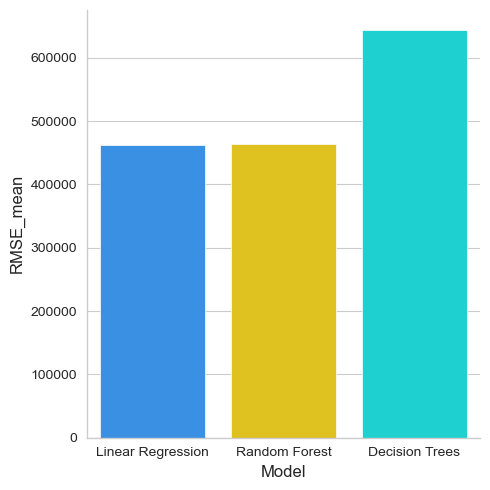

In [67]:
sns.factorplot(x= 'Model', y= 'RMSE_mean', data= modelDF, kind='bar', legend='True')

Now decision trees are not so good in comparison with the other two methods, both in terms of error and variance explained. The best model is random forest, though I must say that I expected it to outperform linear regression by a wider margin. In any case, let's proceed with fine tuning our random forest. 

##### Fine-tune Random Forest

In [68]:
from sklearn.model_selection import GridSearchCV

param_grid = [
{'n_estimators': [10, 25], 'max_features': [5, 10], 
 'max_depth': [10, 50, None], 'bootstrap': [True, False]}
]

grid_search_forest = GridSearchCV(forest, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_forest.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid=[{'bootstrap': [True, False],
                          'max_depth': [10, 50, None], 'max_features': [5, 10],
                          'n_estimators': [10, 25]}],
             scoring='neg_mean_squared_error')

In [69]:
#now let's how the RMSE changes for each parameter configuration
cvres = grid_search_forest.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

448108.5379655603 {'bootstrap': True, 'max_depth': 10, 'max_features': 5, 'n_estimators': 10}
448496.6268121577 {'bootstrap': True, 'max_depth': 10, 'max_features': 5, 'n_estimators': 25}
467398.8081906708 {'bootstrap': True, 'max_depth': 10, 'max_features': 10, 'n_estimators': 10}
455003.4868420753 {'bootstrap': True, 'max_depth': 10, 'max_features': 10, 'n_estimators': 25}
468261.887706952 {'bootstrap': True, 'max_depth': 50, 'max_features': 5, 'n_estimators': 10}
460942.49067200377 {'bootstrap': True, 'max_depth': 50, 'max_features': 5, 'n_estimators': 25}
473571.13479052443 {'bootstrap': True, 'max_depth': 50, 'max_features': 10, 'n_estimators': 10}
463576.453966294 {'bootstrap': True, 'max_depth': 50, 'max_features': 10, 'n_estimators': 25}
462184.34671391326 {'bootstrap': True, 'max_depth': None, 'max_features': 5, 'n_estimators': 10}
458864.3123702103 {'bootstrap': True, 'max_depth': None, 'max_features': 5, 'n_estimators': 25}
469615.4991762694 {'bootstrap': True, 'max_depth': 

In [70]:
#find the best model of grid search
grid_search_forest.best_estimator_

RandomForestRegressor(max_depth=10, max_features=5, n_estimators=10, n_jobs=-1)

In [71]:
# Performance metrics
grid_best= grid_search_forest.best_estimator_.predict(x_train)
errors = abs(grid_best - y_train)
# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / y_train))
# Calculate and display accuracy
accuracy = 100 - mape    
#print result
print('The best model from grid-search has an accuracy of', round(accuracy, 2),'%')

The best model from grid-search has an accuracy of 81.52 %


In [72]:
#RMSE
grid_mse = mean_squared_error(y_train, grid_best)
grid_rmse = np.sqrt(grid_mse)
print('The best model from the grid search has a RMSE of', round(grid_rmse, 2))

The best model from the grid search has a RMSE of 251921.83


<a id='random'></a>

In [73]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 45, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

pprint(random_grid)

{'max_depth': [1, 23, 45],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [5, 10],
 'n_estimators': [20, 65, 110, 155, 200]}


In [74]:

rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 10, cv = 10, verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
                   param_distributions={'max_depth': [1, 23, 45],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [20, 65, 110, 155,
                                                         200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [75]:
#now let's how the RMSE changes for each parameter configuration
cvres2 = rf_random.cv_results_
for mean_score, params in zip(cvres2["mean_test_score"], cvres2["params"]):
    print(np.sqrt(-mean_score), params)

536329.2505301902 {'n_estimators': 20, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 1}
536216.6247951346 {'n_estimators': 20, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 1}
448590.51137374894 {'n_estimators': 65, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 23}
463349.75303040067 {'n_estimators': 20, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 45}
536057.942382122 {'n_estimators': 155, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 1}
445148.1479936438 {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 45}
444748.91977404564 {'n_estimators': 155, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 23}
456873.8830828195 {'n_estimators': 155, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 45}
536677.6248833886 {'n_estimators': 110, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 1}
444630.371870411 {'n_estimators': 110, 'min_samples_split

Best RMSE is (416575.2611)

In [76]:
# best random model 
rf_random.best_estimator_

RandomForestRegressor(max_depth=45, max_features='sqrt', min_samples_split=10,
                      n_estimators=110, n_jobs=-1)

In [77]:
# best combination of parameters of random search
rf_random.best_params_

{'n_estimators': 110,
 'min_samples_split': 10,
 'max_features': 'sqrt',
 'max_depth': 45}

In [78]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=45, max_features='sqrt', min_samples_split=10,
                      n_estimators=110, n_jobs=-1)

Now, let's find out about the performance metrics of our new model: MAPE and RMSE. 

In [79]:
# Performance metrics (MAPE)
random_best= rf_random.best_estimator_.predict(x_train)
errors = abs(random_best - y_train)
# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / y_train))
# Calculate and display accuracy
accuracy = 100 - mape    
#print result
print('The best model from the randomized search has an accuracy of', round(accuracy, 2),'%')

The best model from the randomized search has an accuracy of 81.3 %


In [80]:
#this is the RMSE
final_mse = mean_squared_error(y_train, random_best)
final_rmse = np.sqrt(final_mse)
print('The best model from the randomized search has a RMSE of', round(final_rmse, 2))

The best model from the randomized search has a RMSE of 289250.7


In conclusion, the metrics for our best models on the training set after our hyperparameter fine-tuning are the following:

1. **Grid-search**:
    * RMSE: 181304.01
    * accuracy (MAPE): 89.37 %
    
    
2. **Randomized Search**:
    * RMSE: 291065.23
    * accuracy: 82.04 %


**Feature Importance**

In [81]:
# extract the numerical values of feature importance from the grid search
importances = rf_random.best_estimator_.feature_importances_

#create a feature list from the original dataset (list of columns)
# What are this numbers? Let's get back to the columns of the original dataset
feature_list = list(X.columns)

#create a list of tuples
feature_importance= sorted(zip(importances, feature_list), reverse=True)

#create two lists from the previous list of tuples
df = pd.DataFrame(feature_importance, columns=['importance', 'feature'])
importance= list(df['importance'])
feature= list(df['feature'])

#see df
print(df)

    importance                                   feature
0     0.115618                           Number_of_rooms
1     0.114947                                DistanceKM
2     0.098768                            LandSizeMetres
3     0.079336                                     index
4     0.072882                                 Lattitude
5     0.068576                         BuildinSizeMetres
6     0.061610                                  houseAge
7     0.059448       GeneralRegion_Southern Metropolitan
8     0.055363                                Longtitude
9     0.044217                                  Bathroom
10    0.043415                          No_of_properties
11    0.042058                                    Type_u
12    0.040721                                    Type_h
13    0.034492                                 car_place
14    0.010847                                      Year
15    0.009432                             season_winter
16    0.009169       GeneralReg

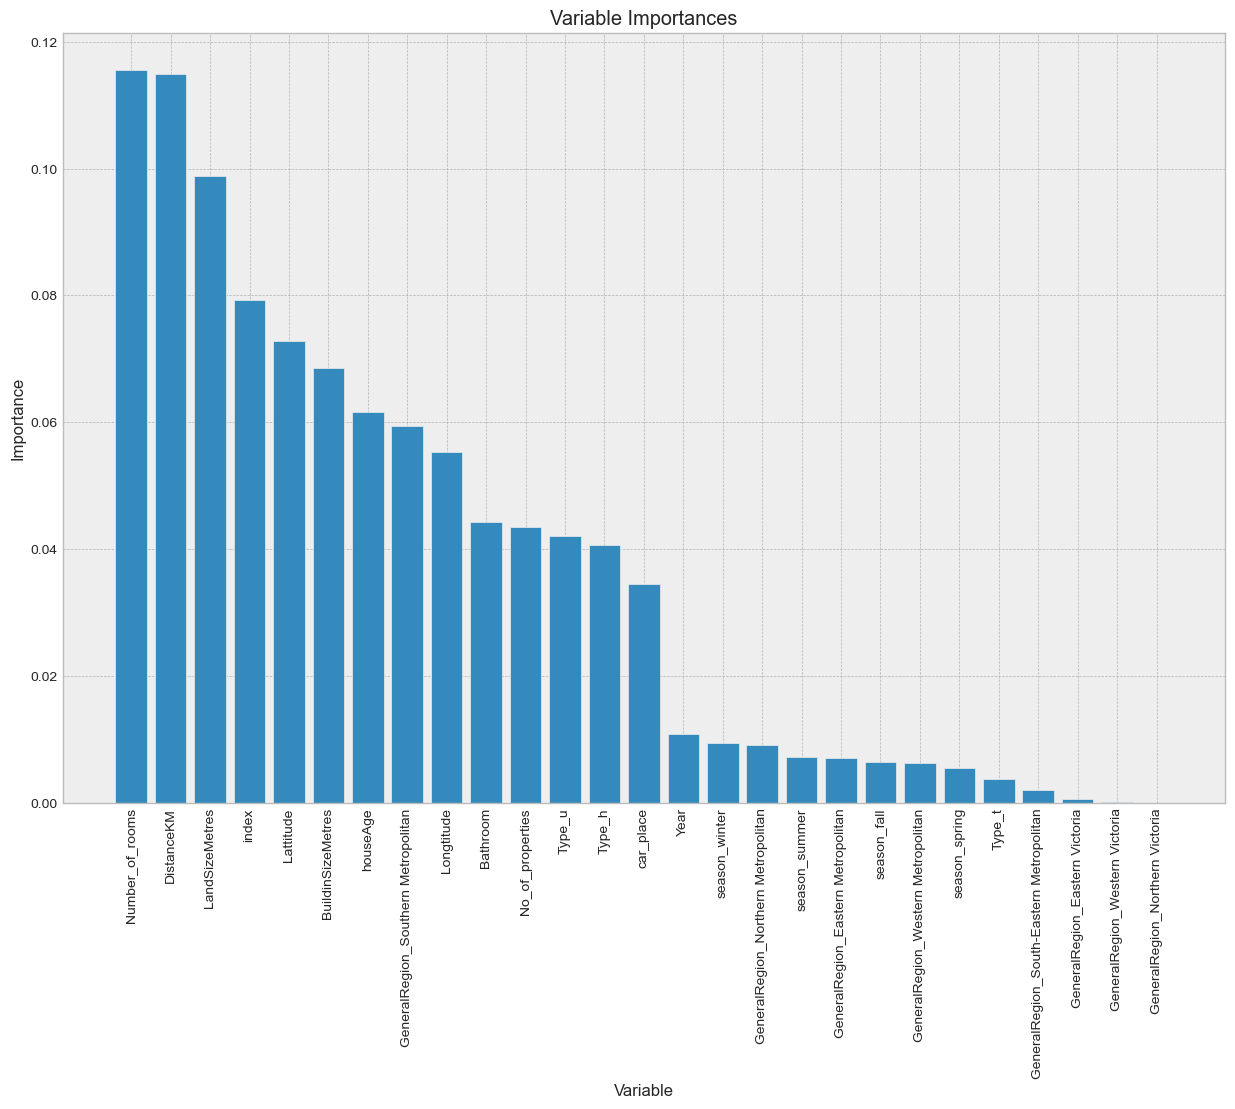

In [82]:
# Set the style
plt.style.use('bmh')
# list of x locations for plotting
x_values = list(range(len(feature_importance)))

# Make a bar chart
plt.figure(figsize=(15,10))
plt.bar(x_values, importance, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

A future aim may be to cut the less relevant features (let's say everything after 'car' in terms of importance), estimate a new model and compare it with the old ones. I reckon it would lose predictive power, but on the other hand it would gain in terms of training speed.  

<a id='evaluate'></a>

#####  Evaluate best model on the test set

In [83]:
final_model = rf_random.best_estimator_
# Predicting test set results
final_pred = final_model.predict(x_test)
final_mse = mean_squared_error(y_test, final_pred)
final_rmse = np.sqrt(final_mse)
print('The final RMSE on the test set is', round(final_rmse, 2))

The final RMSE on the test set is 390376.82


In [84]:
#calculate accuracy
errors = abs(final_pred - y_test)
# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / y_test))
# Calculate and display accuracy
accuracy = 100 - mape    
#print result
print('The best model achieves on the test set an accuracy of', round(accuracy, 2),'%')

The best model achieves on the test set an accuracy of 72.89 %


As was to be expected, the performance drops considerably, but is still  beyond 75%, which I consider a discrete result. 

<a id='hyper'></a>

##### Visualize Random Forest Hyperparameters
I thought to dedicate a last visualization to one of the major hyperparameter that I tweaked in my training: max_depth. Of course this could be done with all the other parameters, but considering it was only a closing remark extending this part seemed pretty useless. 

### max_depth
Max_depth indicates how deep the tree can be. The deeper the tree, the more splits it has and it captures more information about the data. In our search we considered a depth ranging from 1 to 50 on the training set. Let's compare the training result with the test result. 

Text(0.5, 0, 'Tree depth')

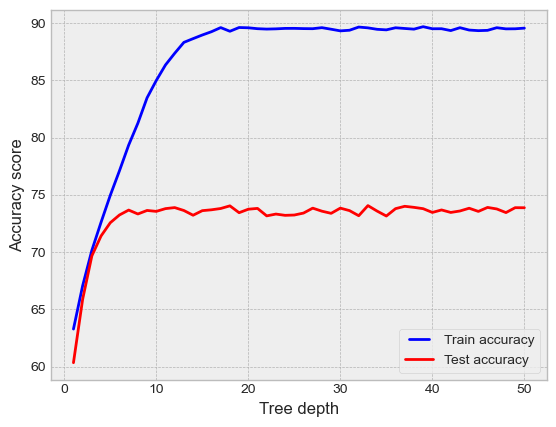

In [85]:
max_depths = np.linspace(1, 50, 50, endpoint=True)

train_results = []
test_results = []

for i in max_depths:
    dt = RandomForestRegressor(max_depth=i)
    dt.fit(x_train, y_train)    
    #compute accuracy for train data
    housing_tree = dt.predict(x_train)
    errors = abs(housing_tree - y_train)
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / y_train)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    #append results of accuracy
    train_results.append(accuracy)
    
    #now again for test data
    housing_tree = dt.predict(x_test)
    errors = abs(housing_tree - y_test)
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / y_test)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    #append results of accuracy
    test_results.append(accuracy)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train accuracy')
line2, = plt.plot(max_depths, test_results, 'r', label= 'Test accuracy')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Tree depth')

With this graph it is really easy to see where the overfitting begins: after ~8 splits the test performance does not increase anymore, while the train stops increasing after 20 splits. In fact, the best model after random search had max_depth=23. This means that the performance of the best model could still be improved if the max_depth was decreased a bit...at least with this test set!


* The best feature to reliably predict the price of a Melbourne house is Distance. After distance that there is a group of 5 features including: number of rooms, Longitude and Latitude, and Southern Metropolitan region. This last dummy attribute is the only one relevant out of the original group of 7 regions. Thus, it seems that the best features are primarily related to the house location, and then to its size (there is also Building size to consider). This is why I chose that title!
* The type of the house seems less important than these two categories, as houseAge and Type_h are respectively 10th and 11th in this ranking. Category Type_t (or townhouse) is the less relevant feature in this cluster. 
* Date features (i.e. Year and the four seasons) are not that important, but in any case the year when the house was sold is slightly more important than the season.

**Future goals**:
* more automation: write a couple of functions to speed up the pre-processing part; Build a pipeline to automate the preprocessing transformations.
